# Game Flow Incorporating Momentum
Takes in the game flow array of probabilities and modifies them according to various explanatory variables.

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools # for shortening double-loop code.
%matplotlib inline
plt.style.use('ggplot')

In [103]:
# Functions

# Probability Functions

# Find the probability of winning a game given probability winning a point
def prob_hold(p):
    """Probability server holds."""
    q = 1-p
    return (
        p**4 +
        4*(p**4)*q + 
        10*(p**4)*(q**2) + 
        (20*(p**3)*(q**3)) * ((p**2)/(1 - 2*p*q))
    )

# Find the probability of winning a set given probability winning a game
def prob_win_set(ps):
    """Probability server holds."""
    qs = 1-ps
    return (
        ps**6 +
        6*(ps**6)*qs + 
        21*(ps**6)*(qs**2) + 
        56*(ps**6)*(qs**3) +
        126*(ps**6)*(qs**4) +
        42*(ps**7)*(qs**5) +
        924*(ps**7)*(qs**6)
    )

# Find the probability of winning a match given probability winning a set
def prob_win_match(pm):
    """Probability server holds."""
    qm = 1-pm
    return (
        pm**3 +
        3*(pm**3)*qm + 
        6*(pm**3)*(qm**2)
    )

def get_serve_probability(match_data, player):
    serve_no = match_data['server'].values
    point_victor = match_data['point_victor'].values

    serve_point_won = 0
    num_serves = 0

    p_array = []

    for index in range(len(serve_no)):
        if player == serve_no[index]:
            num_serves += 1

            if player == point_victor[index]:
                serve_point_won += 1

        if num_serves == 0:
            p_array.append(0)
        else:
            p_array.append(serve_point_won / num_serves)

    return p_array

def prob_win_independent_game(p1, p2):
    p1_holds_game = prob_hold(p1)
    p1_concedes_game = (1 - p1_holds_game)

    p2_holds_game = prob_hold(p2)
    p2_concedes_game = (1 - p2_holds_game)

    ps1 = (p1_holds_game + p2_concedes_game) / 2 # Prob p1 wins any independent game
    ps2 = (p2_holds_game + p1_concedes_game) / 2 # Prob p2 wins any independent game

    return ps1, ps2

# Momentum Modifier Functions

# change probability if player wins set
def modify_momentum(match_data, probability_array, player, r=1.3, q=0.4):
    '''
    When a player wins a set their "points" will increase by an exponential amount. When they lose a set their "points" will decrease but this change isn't as significant.
    '''
    # n = number of sets won
    n = 0
    lost = 0
    loss_factor = 1
    #x = 1.25

    for index in range(len(probability_array)):
        set_victor_array = match_data['set_victor'].values
        won_set = set_victor_array[index] == player

        if (won_set):
            n += 1
            n = n
        elif set_victor_array[index] == 3 - player:
            lost += 1
            # probability_array[index] = probability_array[index]/(2*lost)
            loss_factor = 1 + (q * lost)

        probability_array[index] = (((r**n)-1)/(r**n) + (1/(r**n))*probability_array[index]) ** loss_factor
        

    return probability_array

def modify_momentum_err(match_data, momentum_array, player, s=0.0035):
    '''
    Calculates the total number of unforced errors for a player and their opponent. For each additional unforced error a player commits, they will lose 0.0035 "points.
    For each additional unfrced error their opponent commits, they will gain 0.0035 "points".
    '''
    array = []

    # unforced error total
    n = 0
    m = 0
    #x = 1.001

    unf_err_array = match_data[f'p{player}_unf_err'].values
    for index in range(len(momentum_array)):
        unf_err = unf_err_array[index] == 1

        if (unf_err):
            n += 1

    unf_err_array_2 = match_data[f'p{3-player}_unf_err'].values
    for index in range(len(momentum_array)):
        unf_err_2 = unf_err_array_2[index] == 1

        if (unf_err_2):
            m += 1

        if n>= 0:
            momentum_array[index] = momentum_array[index]-s*n + s*m
            if momentum_array[index] < 0:
                momentum_array[index] = 0
    return momentum_array

In [104]:
# 1 - Calculate serve probability (points_on_serves / total serves)
# 2 - Calculate probability of winning a game from serve probability for each player
# 3 - Calculate probability of winning a set from the player win game probability
# 4 - Calculate probability of winning a match from the player win set probability
# 5 - Graph the probability of winning the set as point values increase

class MarkovChain:
    def __init__(self, file, match_to_examine):
        raw_data = pd.read_csv(file)
        self.match = raw_data[raw_data['match_id'] == match_to_examine]
        self.player1_name = self.match['player1'].values[0]
        self.player2_name = self.match['player2'].values[0]
        self.max_length = 0
        self.p1_momentum = []
        self.p2_momentum = []

    # 1 - Get serve probabilities
    def get_serve_probabilities(self, debug=False):
        p1_probability = get_serve_probability(self.match, 1)
        p2_probability = get_serve_probability(self.match, 2)
    
        if debug:
            print("Probability of winning a serve")
            print(p1_probability)
            print(p2_probability)
    
        # Get the maximum length between both probability arrays
        self.max_length = max(len(p1_probability), len(p2_probability))

        return p1_probability, p2_probability
    

    #  2 - Get probability of winning the game
    def get_game_probabilities(self, p1_probability, p2_probability, debug=False):
        pg1_array = []
        pg2_array = []

        for index in range(self.max_length):
            pg1, pg2 = prob_win_independent_game(p1_probability[index], p2_probability[index])

            pg1_array.append(pg1)
            pg2_array.append(pg2)

        if debug:
            print("Probability of winning the game")
            print(pg1_array)
            print(pg2_array)

        return pg1_array, pg2_array
    
    # 3 - Get probability of winning the set.
    def get_set_probabilities(self, pg1_array, pg2_array, debug=False):
        ps1_array = []
        ps2_array = []

        for index in range(self.max_length):
            ps1_array.append(prob_win_set(pg1_array[index]))
            ps2_array.append(prob_win_set(pg2_array[index]))

        if debug:
            print("Probability of winning the set")
            print(ps1_array)
            print(ps2_array)

        return ps1_array, ps2_array
    
    # 4 - Get probability of winning the match
    def get_match_probabilities(self, ps1_array, ps2_array, debug=False):
        pm1_array = []
        pm2_array = []

        for index in range(self.max_length):
            pm1_array.append(prob_win_match(ps1_array[index]))
            pm2_array.append(prob_win_match(ps2_array[index]))

        if debug:
            print("Probability of winning the match")
            print(pm1_array)
            print(pm2_array)

        return pm1_array, pm2_array
    
    def update_momentum(self, pm1_array, pm2_array, debug=False):
        p1_momentum = modify_momentum(self.match,  pm1_array, 1)
        p2_momentum = modify_momentum(self.match, pm2_array, 2)

        p1_momentum1 = modify_momentum_err(self.match, p1_momentum, 1)
        p2_momentum2 = modify_momentum_err(self.match, p2_momentum, 2)

        if debug:
            print(p1_momentum1)
            print(p2_momentum2)

        return p1_momentum1, p2_momentum2
    
    # 5 - Graph
    def graph_momentum(self):
        # graph the performance of match flow + momentum
        set_change_points = []

        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry

        plt.title("Game Flow")
        plt.plot(range(len(self.p1_momentum)), self.p1_momentum, color="red", label=f"{self.player1_name}")
        plt.plot(range(len(self.p2_momentum)), self.p2_momentum, color="blue", label=f"{self.player2_name}")
        plt.xlabel("Point Number")
        plt.ylabel("Performance Rate")
        plt.legend()

        plt.text(20, -.04, 'Set 1', verticalalignment='bottom')
        for index, value in enumerate(set_change_points):
            plt.axvline(x=value, color='gray', linestyle='--')
            plt.text(value + 20, -.04, f"Set {index + 2}", verticalalignment='bottom')

        plt.show()

    def prediction(self, verbose=True):
        # Find who was performing better before sets 3 4 and 5
        set_change_points = []


        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry
        for index, value in enumerate(set_change_points):
            if index == 1:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_3_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 3 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_3_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 3 with: ", self.p2_momentum[value], "momentum")

            elif index == 2:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_4_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 4 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_4_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 4 with: ", self.p2_momentum[value], "momentum")

            elif index == 3:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_5_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 5 with: ", self.p1_momentum[value], "momentum")
                elif self.p1_momentum[value] < self.p2_momentum[value]:
                    set_5_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 5 with: ", self.p2_momentum[value], "momentum")
                else: 
                    set_5_pred = 0

        set_victors = self.match['set_victor']
        final_point = set_victors.iloc[-1]
        if final_point == 1:
            winner = self.player1_name
        else:
            winner = self.player2_name
        #print(winner, "won the game")

        verbose = True
        if verbose:
            for index, value in enumerate(set_change_points):
                if index == 1:
                    if winner == set_3_pred:
                        print("set 3 prediction is correct")
                    else:
                        print("set 3 prediction is wrong")
    
                elif index == 2:
                    if winner == set_4_pred:
                        print("set 4 prediction is correct")
                    else:
                        print("set 4 prediction is wrong")
                        
                elif index == 3:
                    if winner == set_5_pred:
                        print("set 5 prediction is correct")
                    else:
                        print("set 5 prediction is wrong")
            #

        self.set_change_points = set_change_points
        
        data = np.vstack([self.p1_momentum[self.set_change_points], self.p2_momentum[self.set_change_points]])
        data = data.T
        
        result_array = self.determine_results(data, final_point)

        return result_array
        # return data, final_point
        
    #
    
    def train(self, debug=False):        
        self.p1_momentum, self.p2_momentum = self.update_momentum(
            *self.get_match_probabilities( # 4
                *self.get_set_probabilities( # 3
                    *self.get_game_probabilities( # 2
                        *self.get_serve_probabilities(debug), debug), debug), debug), debug) # 1
        self.p1_momentum = np.array(self.p1_momentum)
        self.p2_momentum = np.array(self.p2_momentum)
        return
    
    def determine_results(self, data, win):
        predicted_winner = 1+(np.diff(data, axis=1) )        

        actual_winner = win*np.ones( np.shape(predicted_winner) )

        winner_number = actual_winner-1
        winner_number

        equal_elements = [i + 2 for i in range(len(predicted_winner)) if math.floor(predicted_winner[i]) == winner_number[i]]


        match_total_sets = len(predicted_winner)+1
        match_length = [i for i in range(2, match_total_sets+1)]
        result_array = np.vstack([1 if elem in equal_elements else 0 for elem in match_length])
        result_array
        #print("The length of the match is:",match_total_sets)
        #print(result_array)

        return result_array

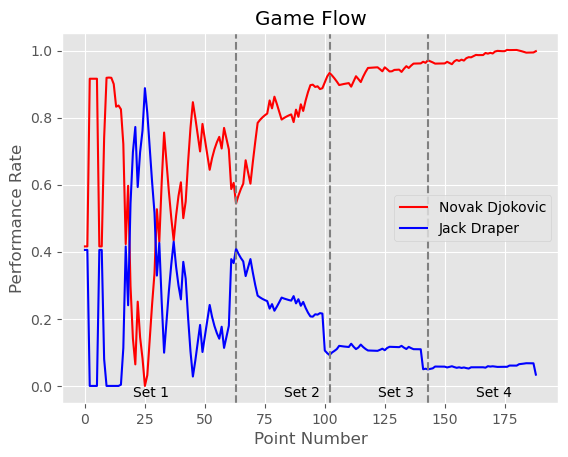

Novak Djokovic is winning going into set 3 with:  0.9333610084429141 momentum
Novak Djokovic is winning going into set 4 with:  0.9710260993812114 momentum
set 3 prediction is correct
set 4 prediction is correct


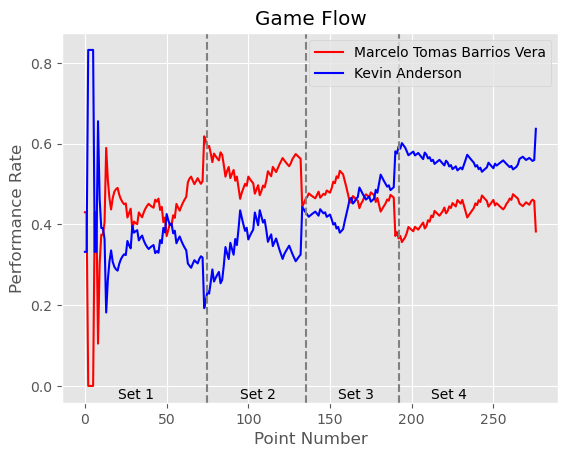

Marcelo Tomas Barrios Vera is winning going into set 3 with:  0.4623158297754675 momentum
Kevin Anderson is winning going into set 4 with:  0.5928713351617775 momentum
set 3 prediction is wrong
set 4 prediction is correct


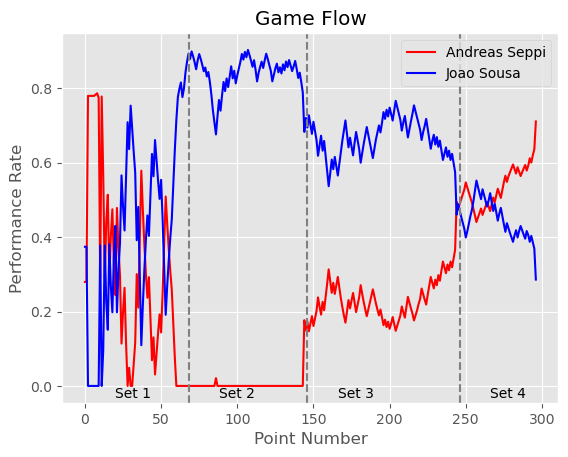

Joao Sousa is winning going into set 3 with:  0.6945124814186018 momentum
Andreas Seppi is winning going into set 4 with:  0.48922613913573754 momentum
set 3 prediction is wrong
set 4 prediction is correct


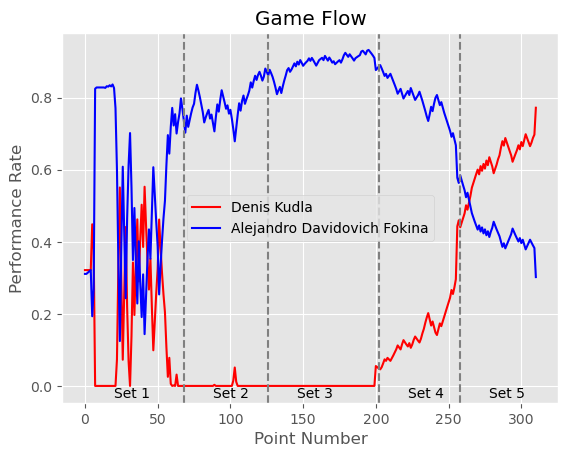

Alejandro Davidovich Fokina is winning going into set 3 with:  0.8618243773216957 momentum
Alejandro Davidovich Fokina is winning going into set 4 with:  0.8862681646306478 momentum
Alejandro Davidovich Fokina is winning going into set 5 with:  0.5845552405040952 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is wrong


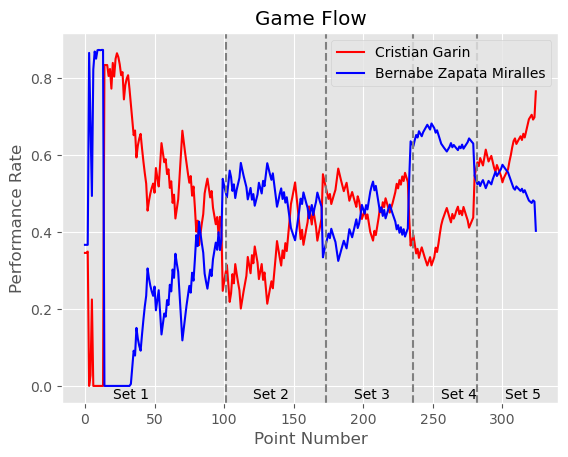

Cristian Garin is winning going into set 3 with:  0.5173372479277893 momentum
Bernabe Zapata Miralles is winning going into set 4 with:  0.6238019147411327 momentum
Cristian Garin is winning going into set 5 with:  0.5815469742978601 momentum
set 3 prediction is correct
set 4 prediction is wrong
set 5 prediction is correct


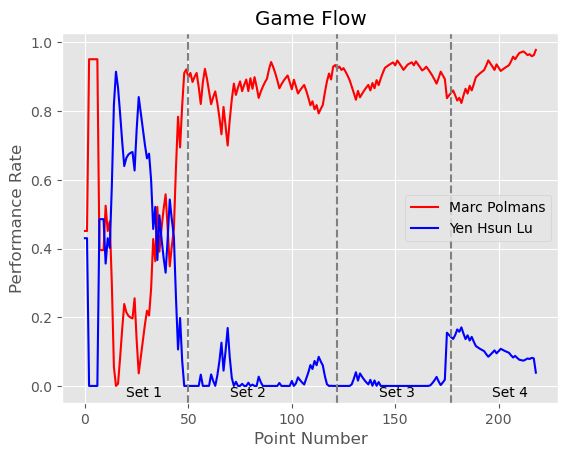

Marc Polmans is winning going into set 3 with:  0.9246796897730655 momentum
Marc Polmans is winning going into set 4 with:  0.8531869367919599 momentum
set 3 prediction is correct
set 4 prediction is correct


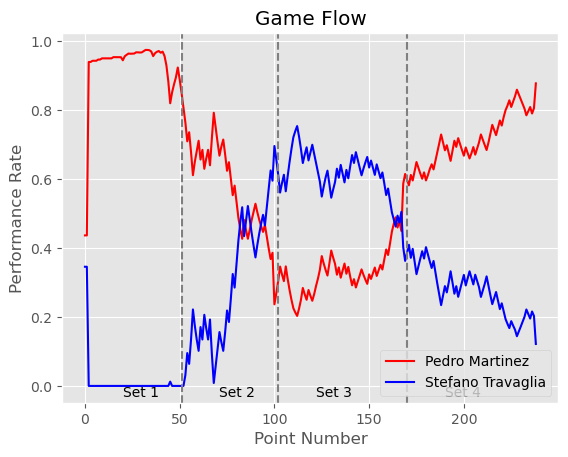

Stefano Travaglia is winning going into set 3 with:  0.6129433794302751 momentum
Pedro Martinez is winning going into set 4 with:  0.5983927549954342 momentum
set 3 prediction is wrong
set 4 prediction is correct


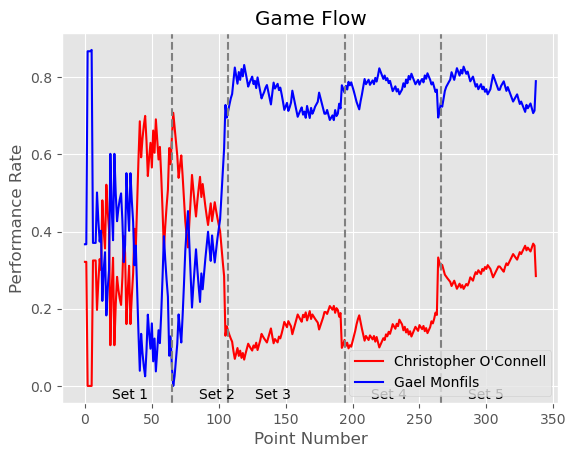

Gael Monfils is winning going into set 3 with:  0.7112171049226127 momentum
Gael Monfils is winning going into set 4 with:  0.7601661225138531 momentum
Gael Monfils is winning going into set 5 with:  0.7339771220789373 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


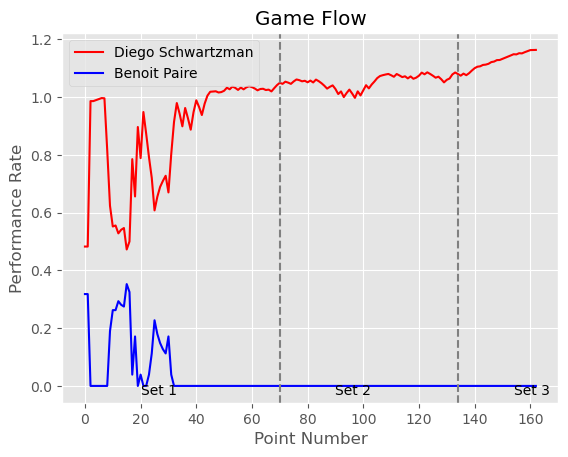

Diego Schwartzman is winning going into set 3 with:  1.0798376762546584 momentum
set 3 prediction is correct


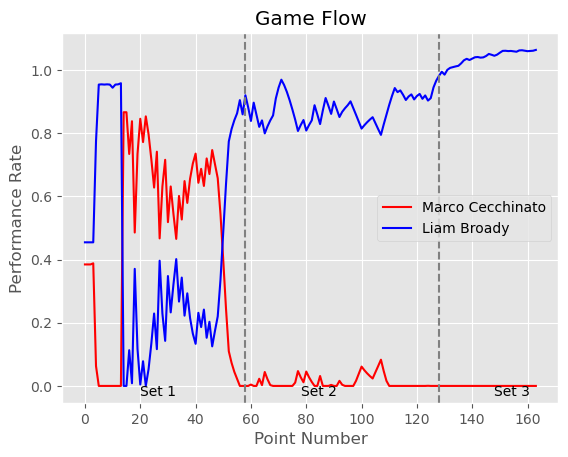

Liam Broady is winning going into set 3 with:  0.9816472107015126 momentum
set 3 prediction is correct


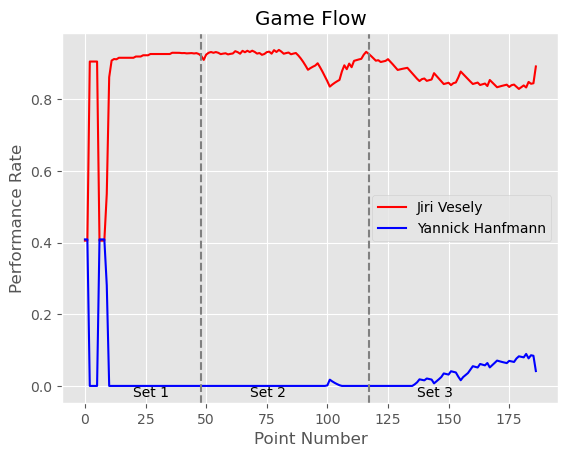

Jiri Vesely is winning going into set 3 with:  0.9270777888117357 momentum
set 3 prediction is correct


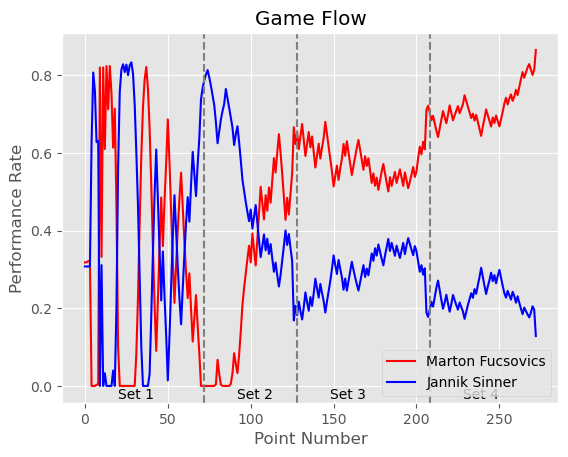

Marton Fucsovics is winning going into set 3 with:  0.652739005692323 momentum
Marton Fucsovics is winning going into set 4 with:  0.7029177758869151 momentum
set 3 prediction is correct
set 4 prediction is correct


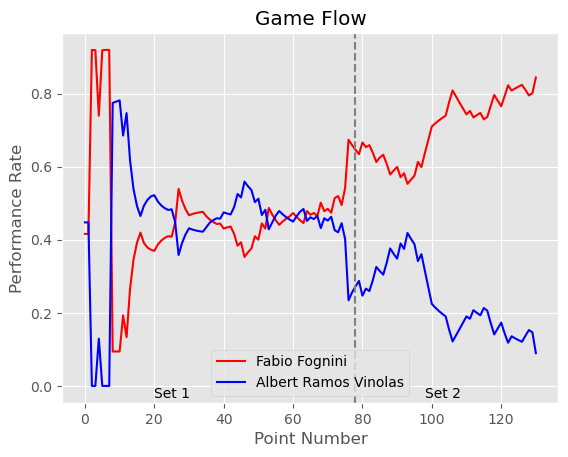

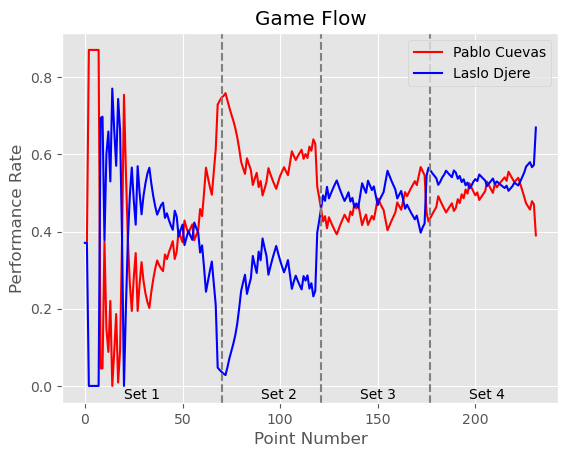

Laslo Djere is winning going into set 3 with:  0.4612983344706143 momentum
Laslo Djere is winning going into set 4 with:  0.5577570142994476 momentum
set 3 prediction is correct
set 4 prediction is correct


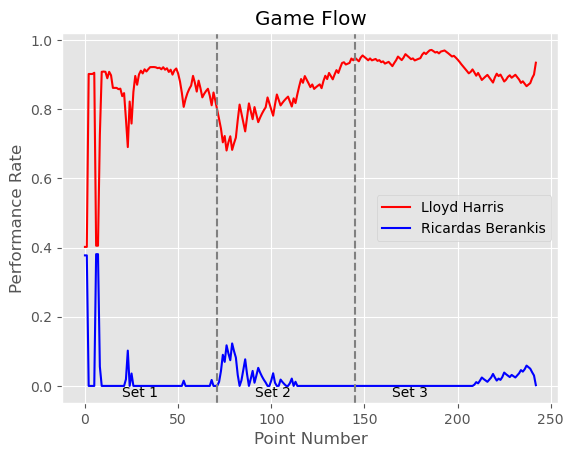

Lloyd Harris is winning going into set 3 with:  0.9486383506054303 momentum
set 3 prediction is correct


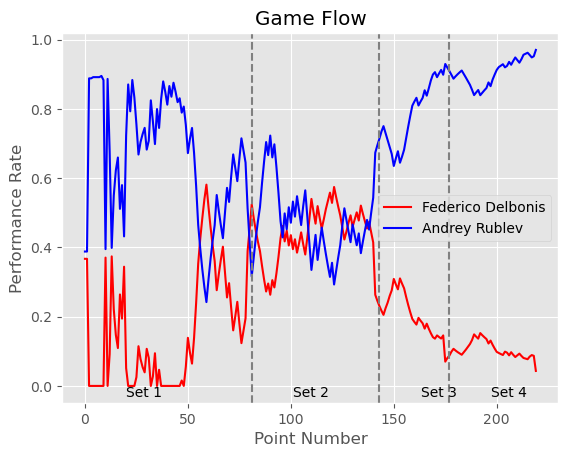

Andrey Rublev is winning going into set 3 with:  0.713437683865383 momentum
Andrey Rublev is winning going into set 4 with:  0.9090711302890173 momentum
set 3 prediction is correct
set 4 prediction is correct


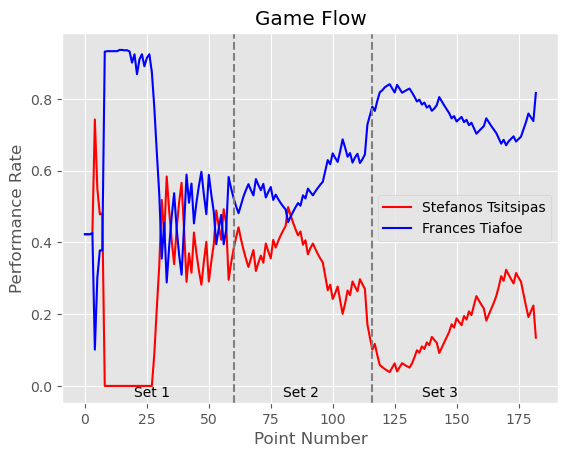

Frances Tiafoe is winning going into set 3 with:  0.7790814650684248 momentum
set 3 prediction is correct


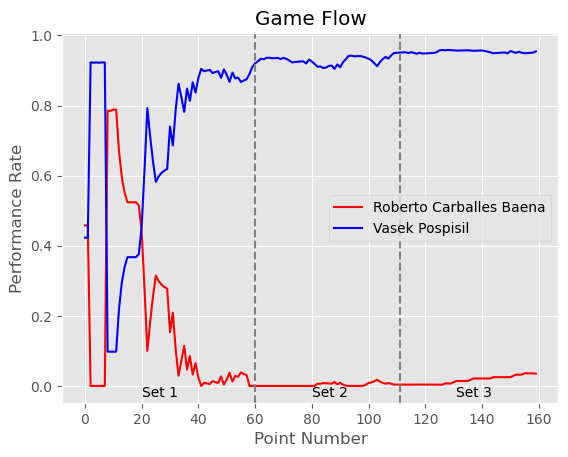

Vasek Pospisil is winning going into set 3 with:  0.9511087859642228 momentum
set 3 prediction is correct


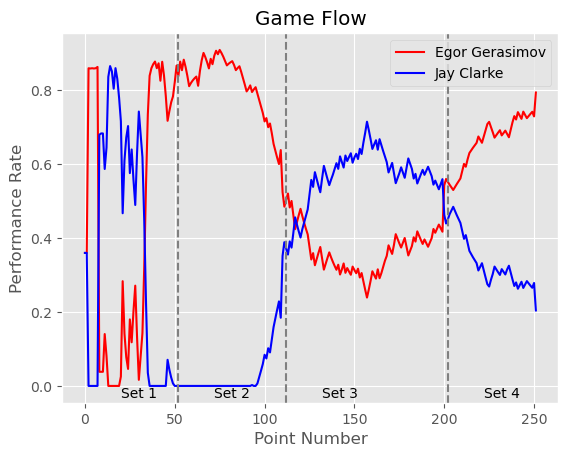

Egor Gerasimov is winning going into set 3 with:  0.5037225823678642 momentum
Egor Gerasimov is winning going into set 4 with:  0.5521567027467441 momentum
set 3 prediction is correct
set 4 prediction is correct


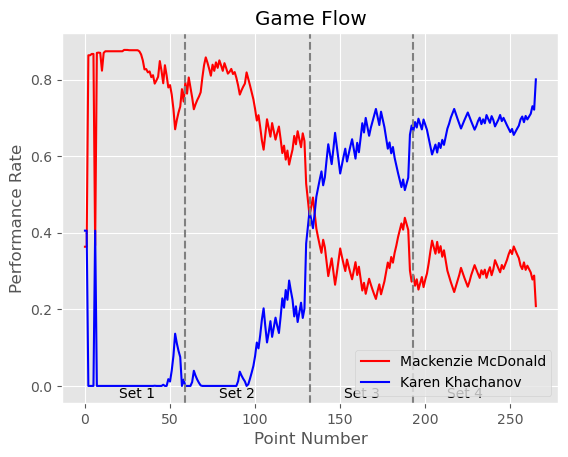

Karen Khachanov is winning going into set 3 with:  0.4576289586864671 momentum
Karen Khachanov is winning going into set 4 with:  0.6656471393433359 momentum
set 3 prediction is correct
set 4 prediction is correct


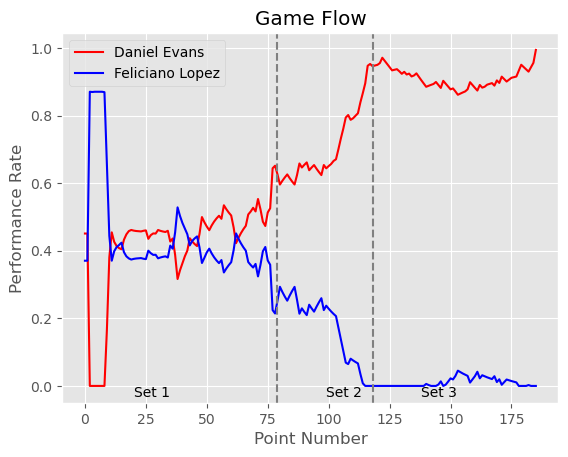

Daniel Evans is winning going into set 3 with:  0.9462537733910418 momentum
set 3 prediction is correct


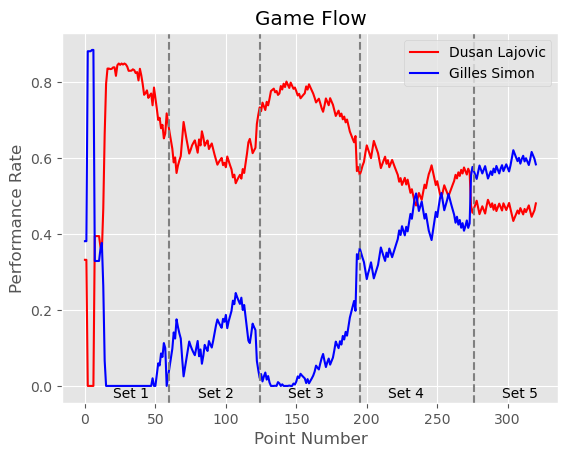

Dusan Lajovic is winning going into set 3 with:  0.7332678799908334 momentum
Dusan Lajovic is winning going into set 4 with:  0.5553498355531106 momentum
Gilles Simon is winning going into set 5 with:  0.5655641563037015 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is correct


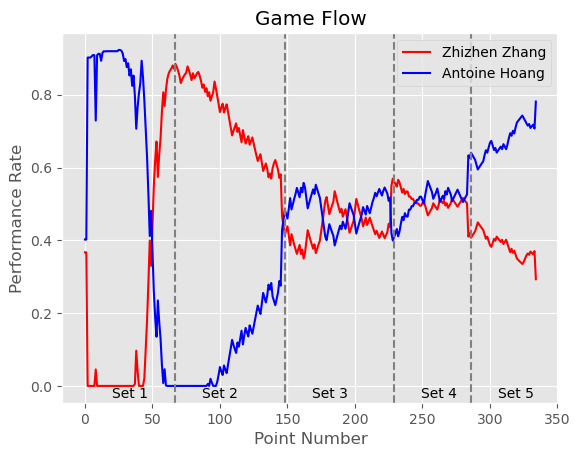

Antoine Hoang is winning going into set 3 with:  0.4839752149653122 momentum
Zhizhen Zhang is winning going into set 4 with:  0.5616030434332687 momentum
Antoine Hoang is winning going into set 5 with:  0.6405452662243245 momentum
set 3 prediction is correct
set 4 prediction is wrong
set 5 prediction is correct


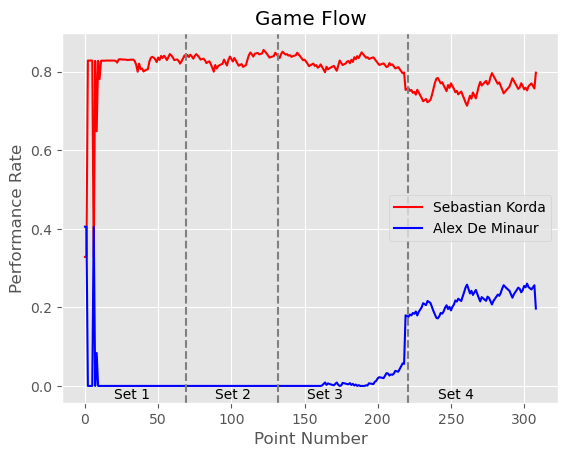

Sebastian Korda is winning going into set 3 with:  0.8395619801419004 momentum
Sebastian Korda is winning going into set 4 with:  0.7584736430295025 momentum
set 3 prediction is correct
set 4 prediction is correct


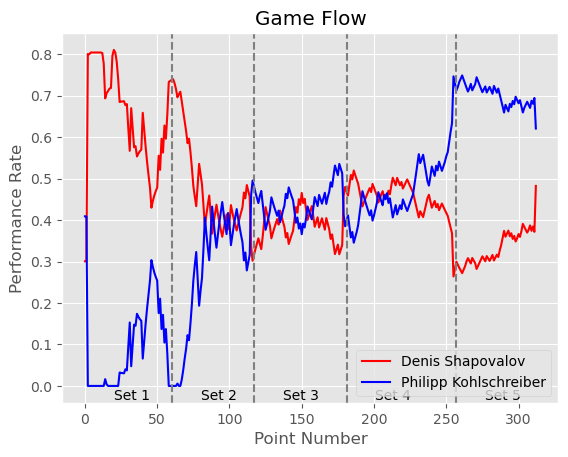

Philipp Kohlschreiber is winning going into set 3 with:  0.4800240442940388 momentum
Denis Shapovalov is winning going into set 4 with:  0.46920903654608376 momentum
Philipp Kohlschreiber is winning going into set 5 with:  0.712326917254067 momentum
set 3 prediction is wrong
set 4 prediction is correct
set 5 prediction is wrong


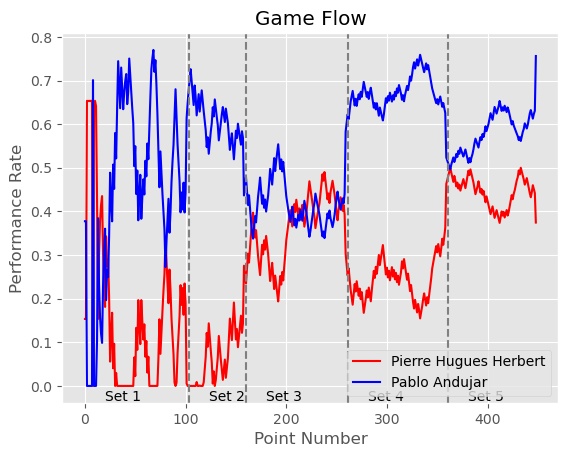

Pablo Andujar is winning going into set 3 with:  0.4784445531782511 momentum
Pablo Andujar is winning going into set 4 with:  0.6223767062182101 momentum
Pablo Andujar is winning going into set 5 with:  0.509329474407092 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


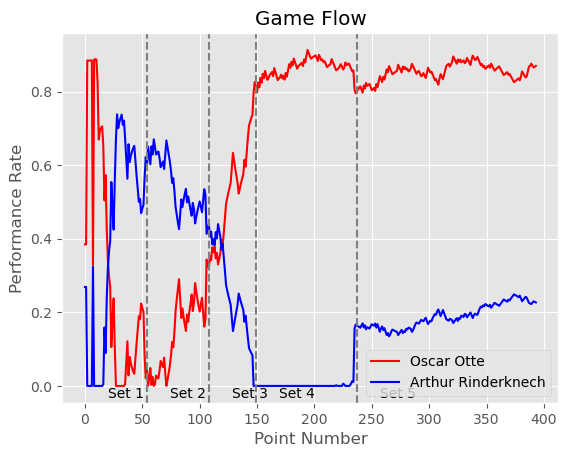

Arthur Rinderknech is winning going into set 3 with:  0.4392562232133518 momentum
Oscar Otte is winning going into set 4 with:  0.8120735830533481 momentum
Oscar Otte is winning going into set 5 with:  0.8015671692970429 momentum
set 3 prediction is correct
set 4 prediction is wrong
set 5 prediction is wrong


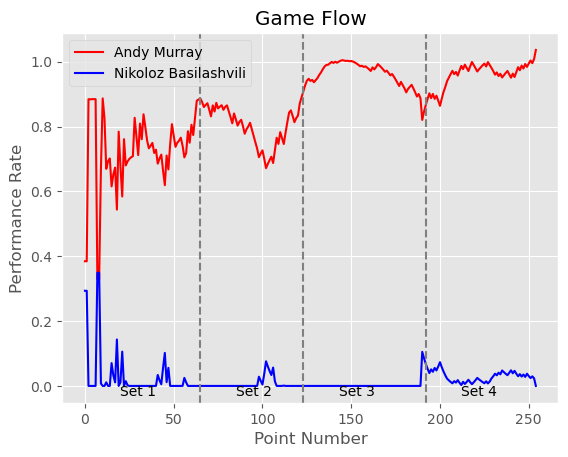

Andy Murray is winning going into set 3 with:  0.9091999853851874 momentum
Andy Murray is winning going into set 4 with:  0.8663611224392888 momentum
set 3 prediction is correct
set 4 prediction is correct


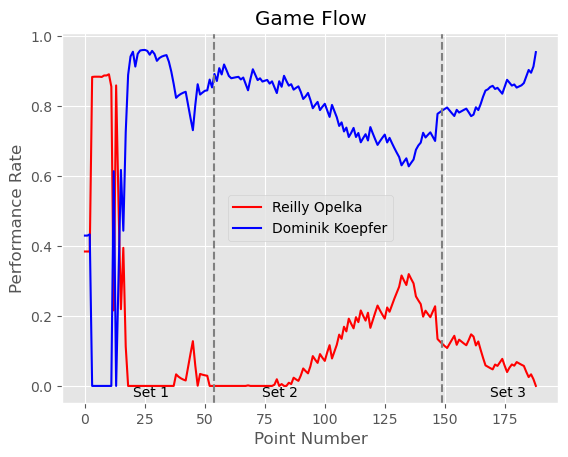

Dominik Koepfer is winning going into set 3 with:  0.7878968813559107 momentum
set 3 prediction is correct


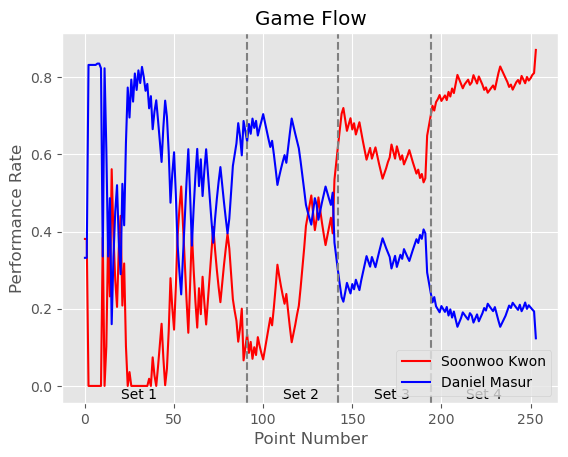

Soonwoo Kwon is winning going into set 3 with:  0.6228895111748118 momentum
Soonwoo Kwon is winning going into set 4 with:  0.7000873888473926 momentum
set 3 prediction is correct
set 4 prediction is correct


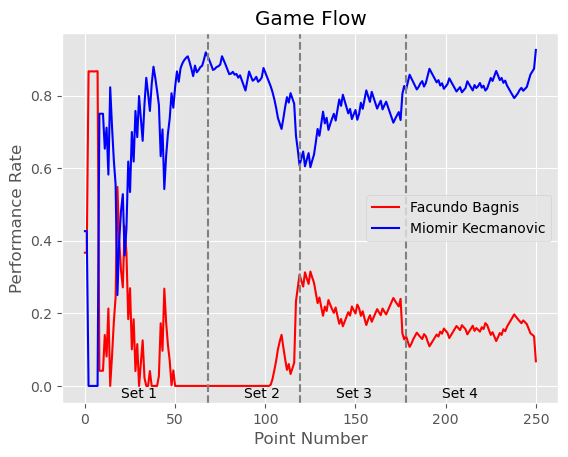

Miomir Kecmanovic is winning going into set 3 with:  0.6076708813186812 momentum
Miomir Kecmanovic is winning going into set 4 with:  0.8158712787338914 momentum
set 3 prediction is correct
set 4 prediction is correct


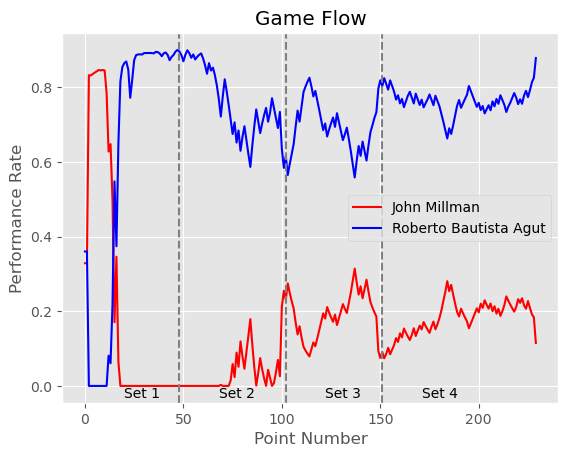

Roberto Bautista Agut is winning going into set 3 with:  0.6158352184181568 momentum
Roberto Bautista Agut is winning going into set 4 with:  0.8026398997695141 momentum
set 3 prediction is correct
set 4 prediction is correct


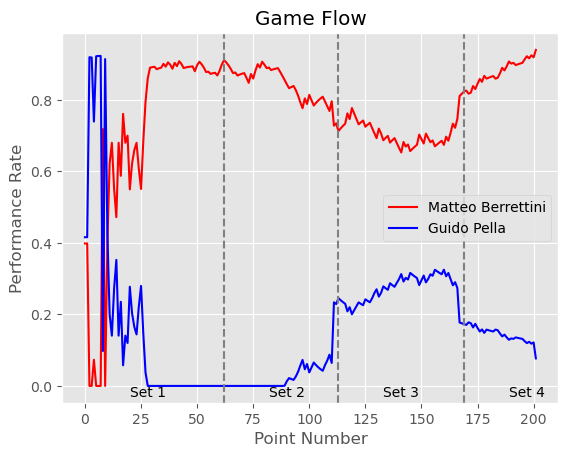

Matteo Berrettini is winning going into set 3 with:  0.7127794991984253 momentum
Matteo Berrettini is winning going into set 4 with:  0.8236578159021739 momentum
set 3 prediction is correct
set 4 prediction is correct


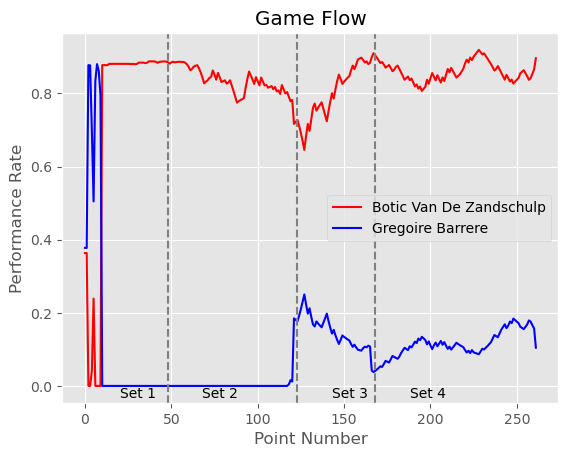

Botic Van De Zandschulp is winning going into set 3 with:  0.7273316703768304 momentum
Botic Van De Zandschulp is winning going into set 4 with:  0.9043353135673702 momentum
set 3 prediction is correct
set 4 prediction is correct


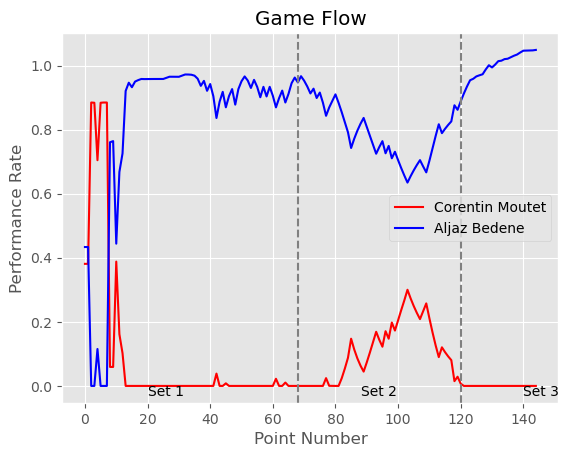

Aljaz Bedene is winning going into set 3 with:  0.8880297311037493 momentum
set 3 prediction is correct


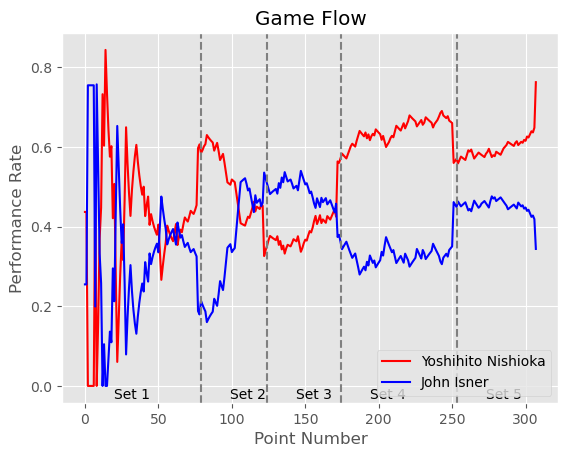

John Isner is winning going into set 3 with:  0.5076451361839823 momentum
Yoshihito Nishioka is winning going into set 4 with:  0.5713576920027932 momentum
Yoshihito Nishioka is winning going into set 5 with:  0.5703567573551439 momentum
set 3 prediction is wrong
set 4 prediction is correct
set 5 prediction is correct


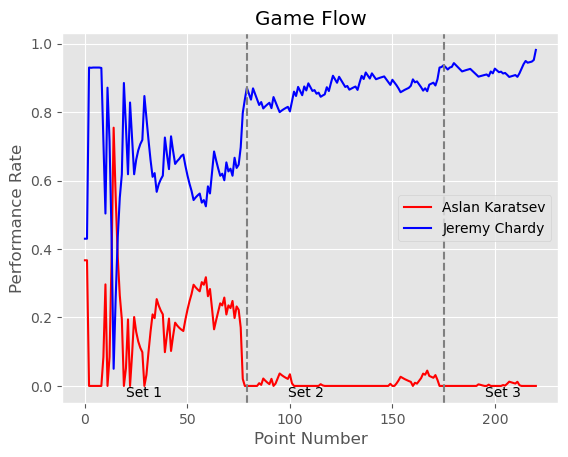

Jeremy Chardy is winning going into set 3 with:  0.9368071138423621 momentum
set 3 prediction is correct


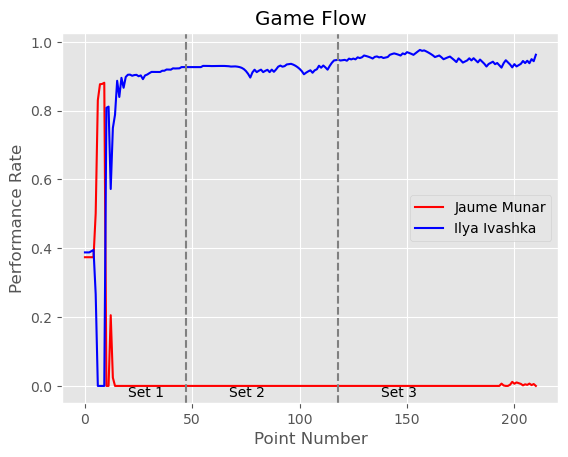

Ilya Ivashka is winning going into set 3 with:  0.9477311197053389 momentum
set 3 prediction is correct


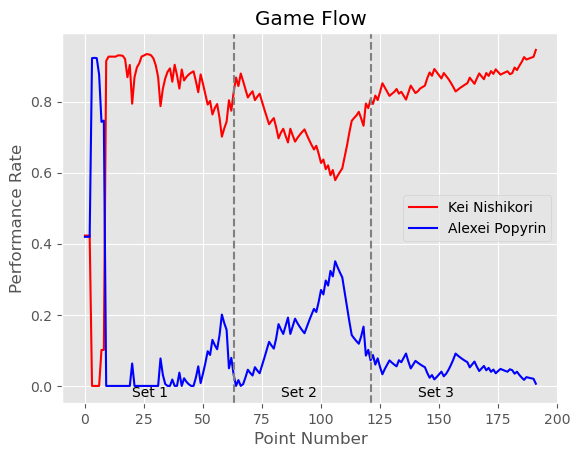

Kei Nishikori is winning going into set 3 with:  0.8062449135055806 momentum
set 3 prediction is correct


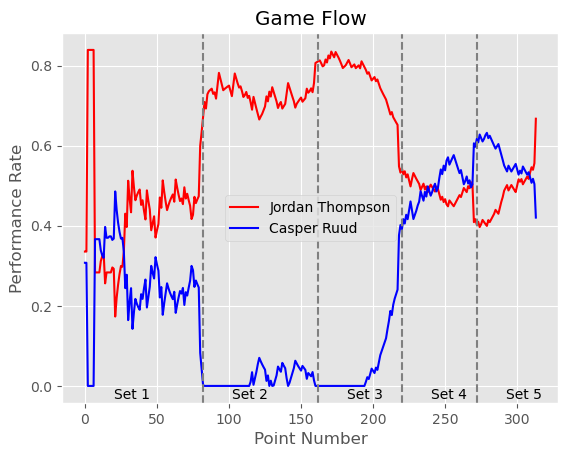

Jordan Thompson is winning going into set 3 with:  0.8108272554171412 momentum
Jordan Thompson is winning going into set 4 with:  0.5437809307105814 momentum
Casper Ruud is winning going into set 5 with:  0.6168992139696858 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is wrong


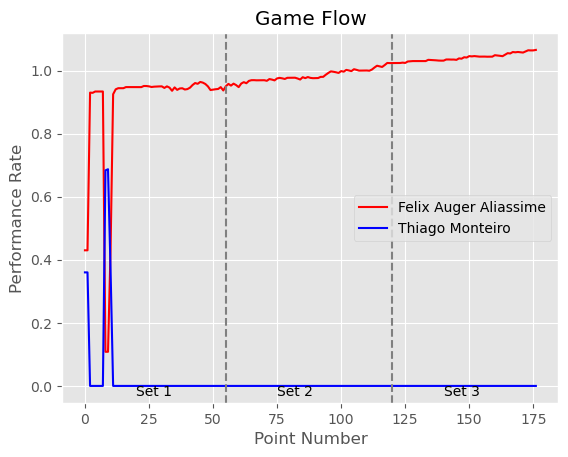

Felix Auger Aliassime is winning going into set 3 with:  1.0236910755141726 momentum
set 3 prediction is correct


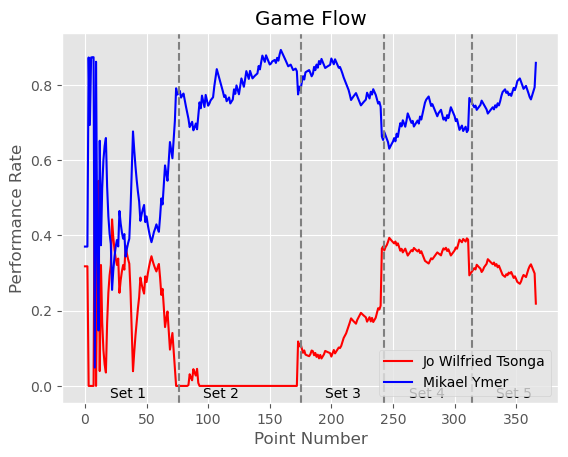

Mikael Ymer is winning going into set 3 with:  0.7868494152700028 momentum
Mikael Ymer is winning going into set 4 with:  0.6749589206490645 momentum
Mikael Ymer is winning going into set 5 with:  0.7530701985124983 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


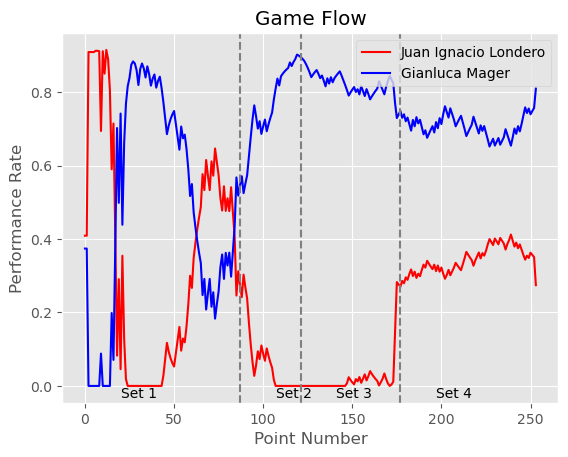

Gianluca Mager is winning going into set 3 with:  0.8955652076402392 momentum
Gianluca Mager is winning going into set 4 with:  0.7485078501888771 momentum
set 3 prediction is correct
set 4 prediction is correct


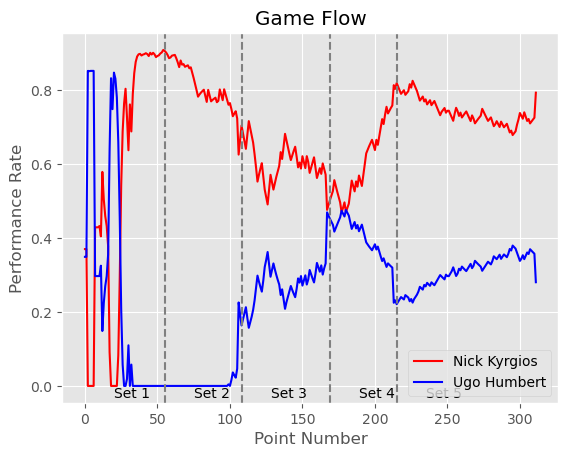

Nick Kyrgios is winning going into set 3 with:  0.7049484387574934 momentum
Nick Kyrgios is winning going into set 4 with:  0.5035098378748929 momentum
Nick Kyrgios is winning going into set 5 with:  0.8202413822854923 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


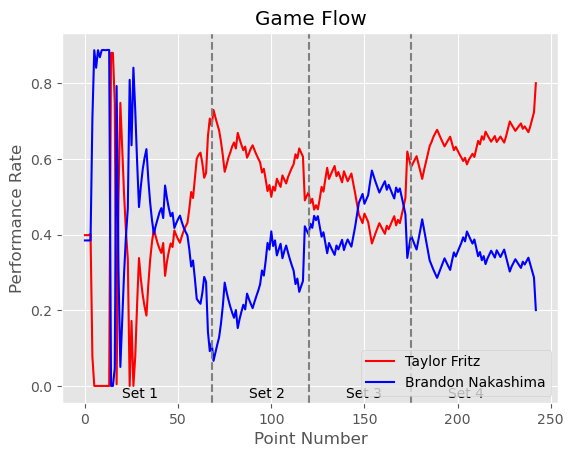

Taylor Fritz is winning going into set 3 with:  0.5118142070632935 momentum
Taylor Fritz is winning going into set 4 with:  0.577970198564639 momentum
set 3 prediction is correct
set 4 prediction is correct


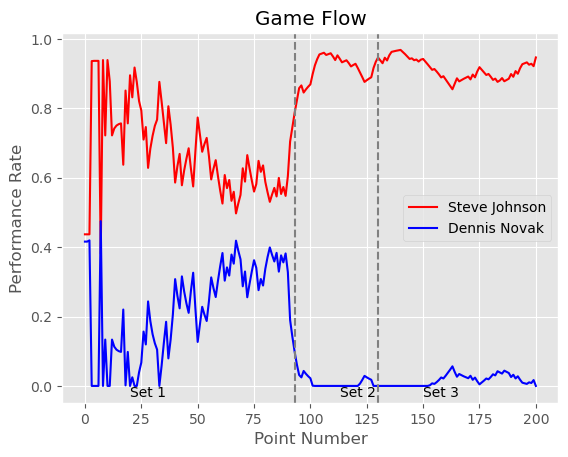

Steve Johnson is winning going into set 3 with:  0.9467029216899502 momentum
set 3 prediction is correct


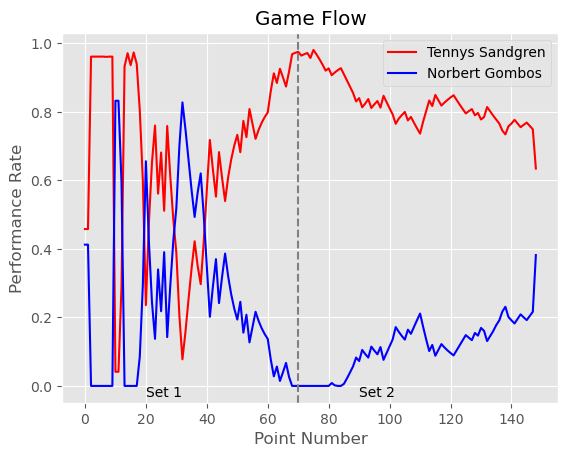

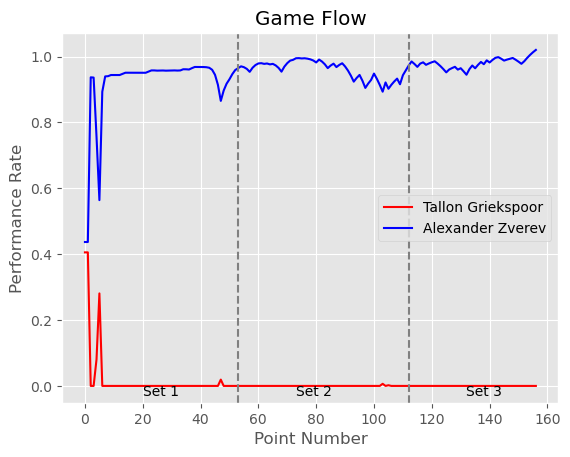

Alexander Zverev is winning going into set 3 with:  0.9727967400814448 momentum
set 3 prediction is correct


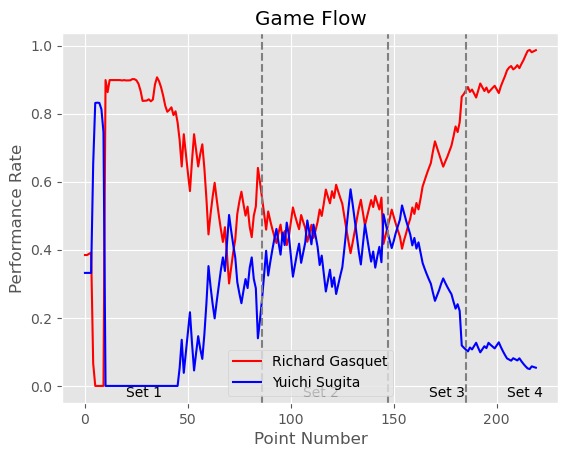

Richard Gasquet is winning going into set 3 with:  0.4675203173874798 momentum
Richard Gasquet is winning going into set 4 with:  0.867853883097195 momentum
set 3 prediction is wrong
set 4 prediction is wrong


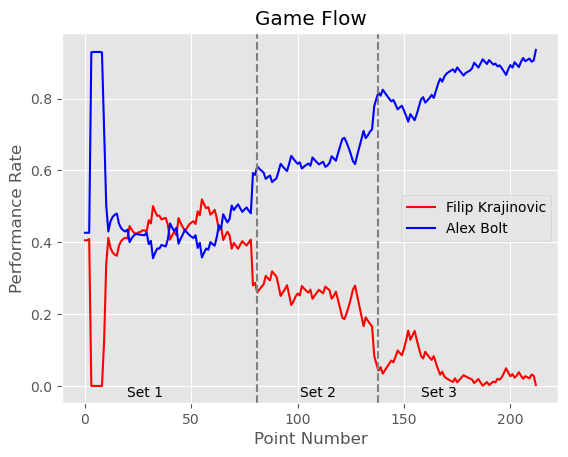

Alex Bolt is winning going into set 3 with:  0.816760263326906 momentum
set 3 prediction is correct


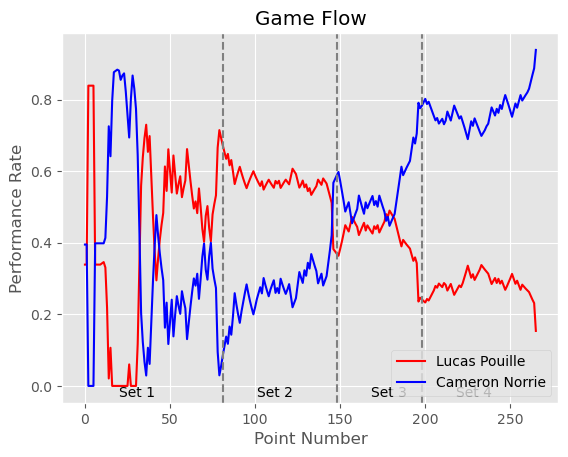

Cameron Norrie is winning going into set 3 with:  0.5884217109125329 momentum
Cameron Norrie is winning going into set 4 with:  0.7827447654629437 momentum
set 3 prediction is correct
set 4 prediction is correct


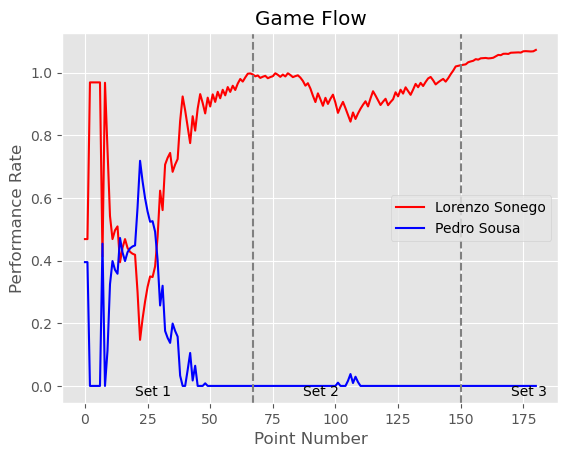

Lorenzo Sonego is winning going into set 3 with:  1.0232357499465614 momentum
set 3 prediction is correct


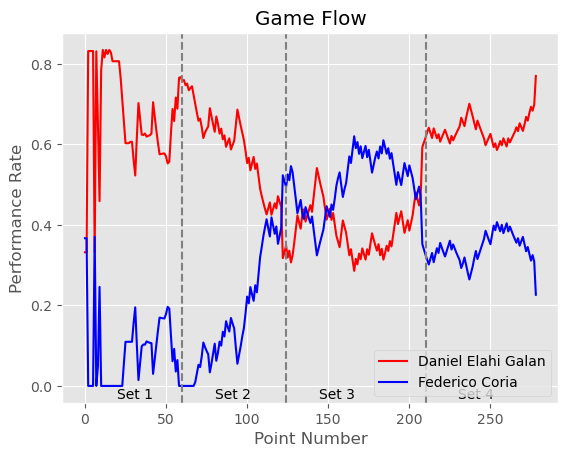

Federico Coria is winning going into set 3 with:  0.49403426111664506 momentum
Daniel Elahi Galan is winning going into set 4 with:  0.6166580941707349 momentum
set 3 prediction is wrong
set 4 prediction is correct


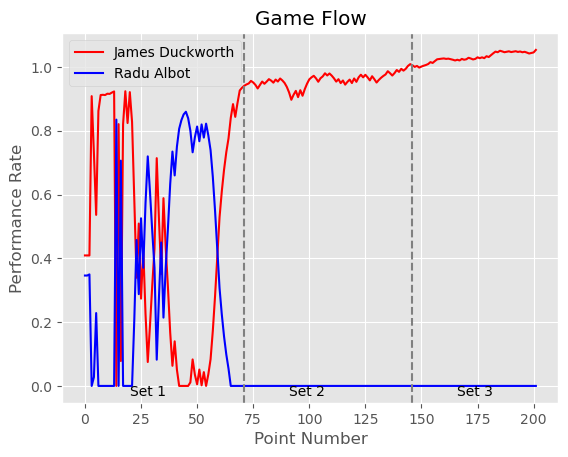

James Duckworth is winning going into set 3 with:  1.0048161117099217 momentum
set 3 prediction is correct


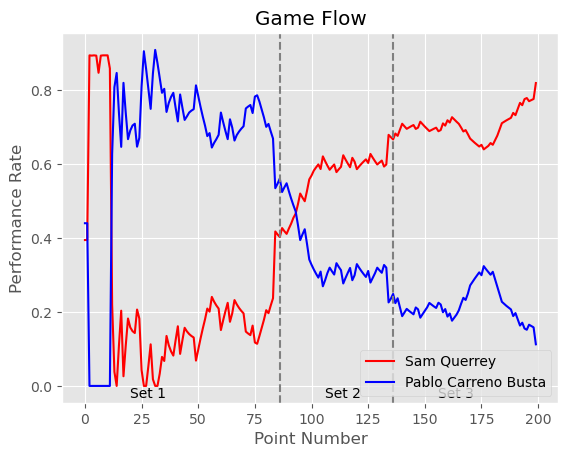

Sam Querrey is winning going into set 3 with:  0.6673397554059414 momentum
set 3 prediction is correct


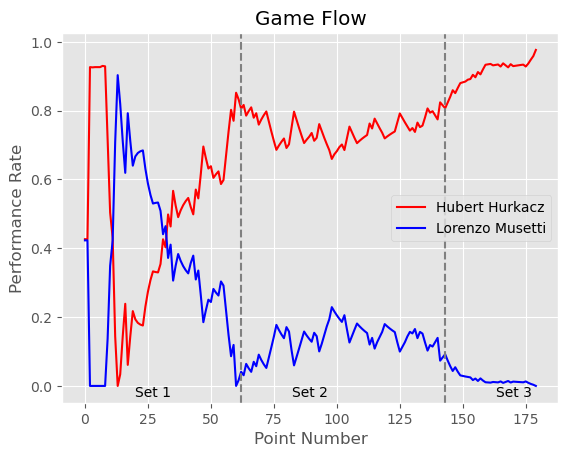

Hubert Hurkacz is winning going into set 3 with:  0.8069250896085505 momentum
set 3 prediction is correct


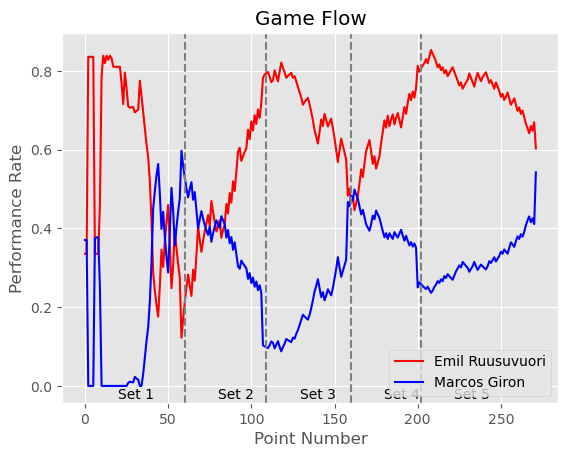

Emil Ruusuvuori is winning going into set 3 with:  0.793847731317363 momentum
Marcos Giron is winning going into set 4 with:  0.48286401969422155 momentum
Emil Ruusuvuori is winning going into set 5 with:  0.8057001911943402 momentum
set 3 prediction is wrong
set 4 prediction is correct
set 5 prediction is wrong


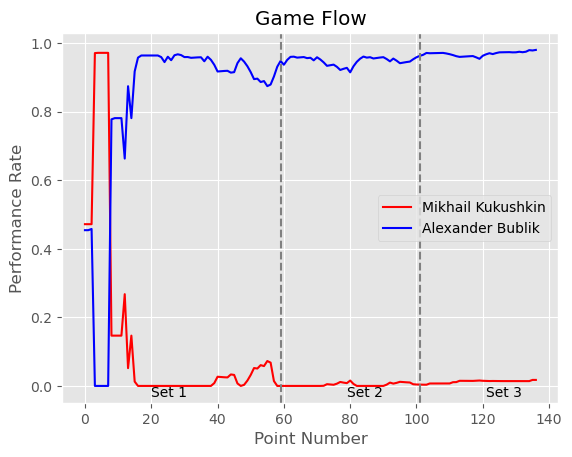

Alexander Bublik is winning going into set 3 with:  0.9632742422944061 momentum
set 3 prediction is correct


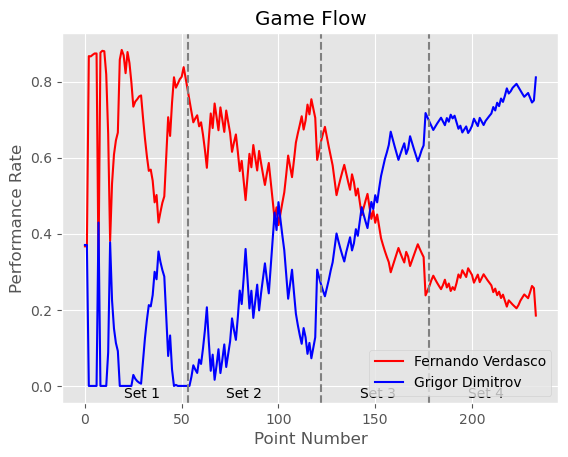

Fernando Verdasco is winning going into set 3 with:  0.6431095007075437 momentum
Grigor Dimitrov is winning going into set 4 with:  0.6944233295931537 momentum
set 3 prediction is wrong
set 4 prediction is correct


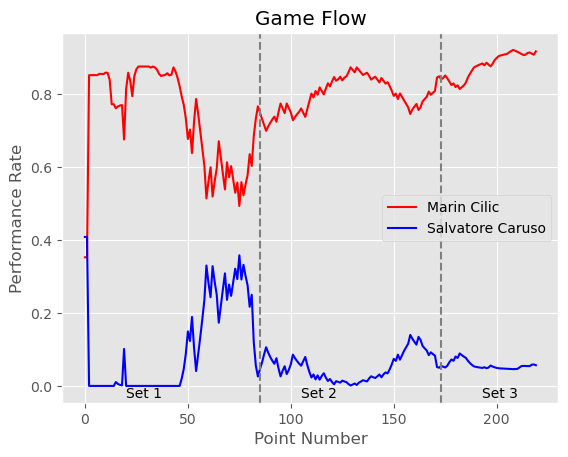

Marin Cilic is winning going into set 3 with:  0.841768876783135 momentum
set 3 prediction is correct


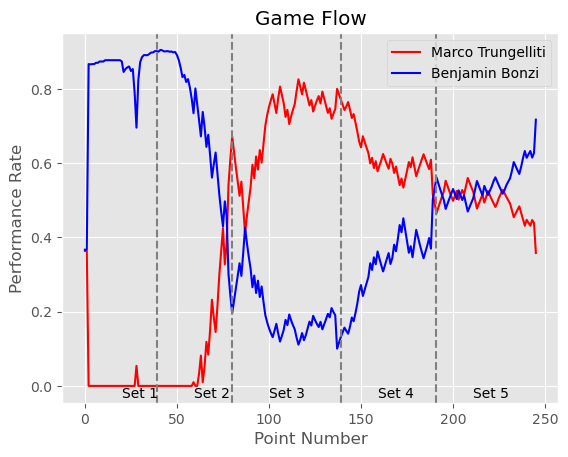

Marco Trungelliti is winning going into set 3 with:  0.6717729482133464 momentum
Marco Trungelliti is winning going into set 4 with:  0.7717485375954204 momentum
Benjamin Bonzi is winning going into set 5 with:  0.5619968534282728 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is correct


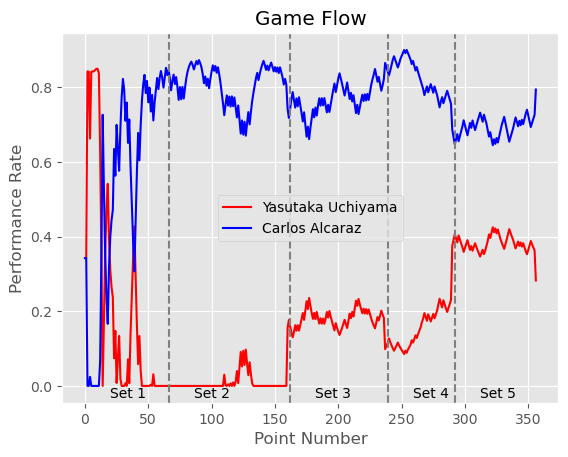

Carlos Alcaraz is winning going into set 3 with:  0.7421037175686774 momentum
Carlos Alcaraz is winning going into set 4 with:  0.8432524952414093 momentum
Carlos Alcaraz is winning going into set 5 with:  0.6470116779073977 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


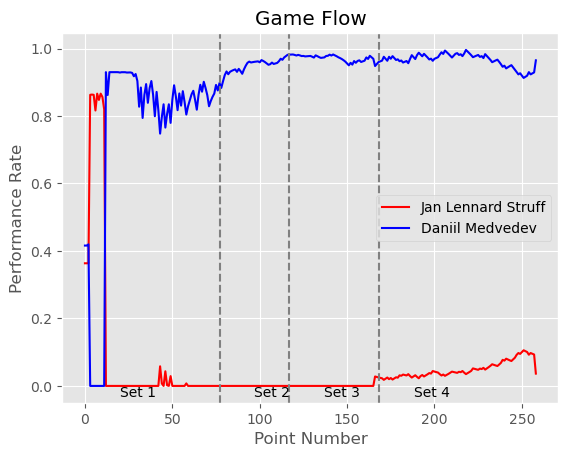

Daniil Medvedev is winning going into set 3 with:  0.9818472687562114 momentum
Daniil Medvedev is winning going into set 4 with:  0.9599983986687691 momentum
set 3 prediction is correct
set 4 prediction is correct


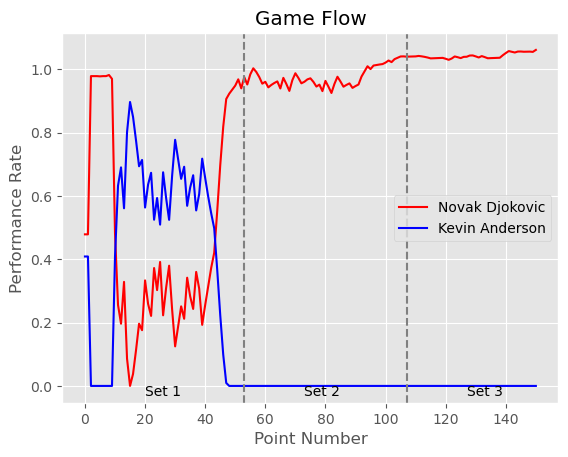

Novak Djokovic is winning going into set 3 with:  1.040516641011552 momentum
set 3 prediction is correct


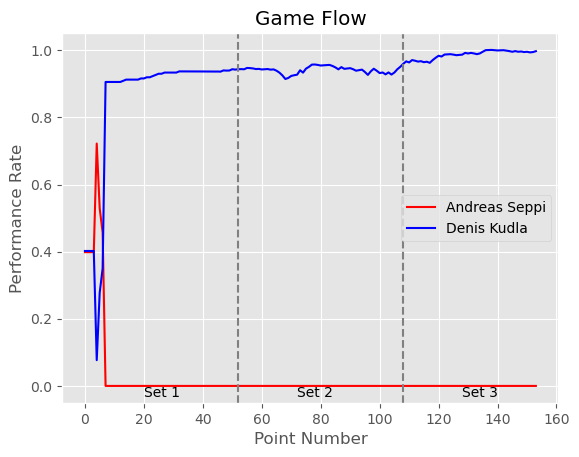

Denis Kudla is winning going into set 3 with:  0.959480519130764 momentum
set 3 prediction is correct


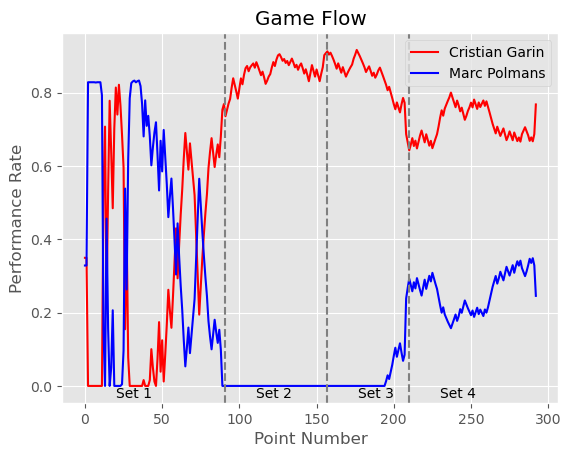

Cristian Garin is winning going into set 3 with:  0.9126834937813785 momentum
Cristian Garin is winning going into set 4 with:  0.6426441337138102 momentum
set 3 prediction is correct
set 4 prediction is correct


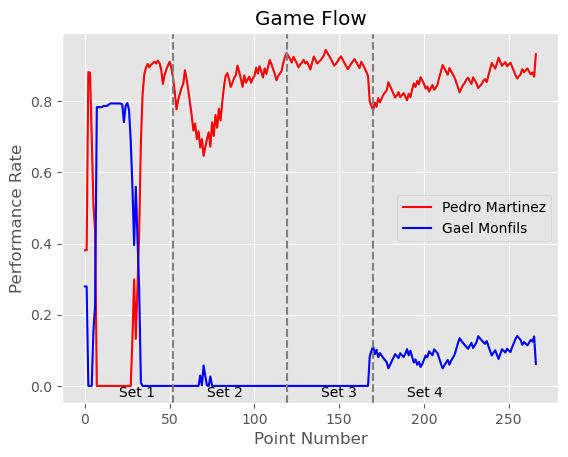

Pedro Martinez is winning going into set 3 with:  0.934691633761472 momentum
Pedro Martinez is winning going into set 4 with:  0.7742827907514807 momentum
set 3 prediction is correct
set 4 prediction is correct


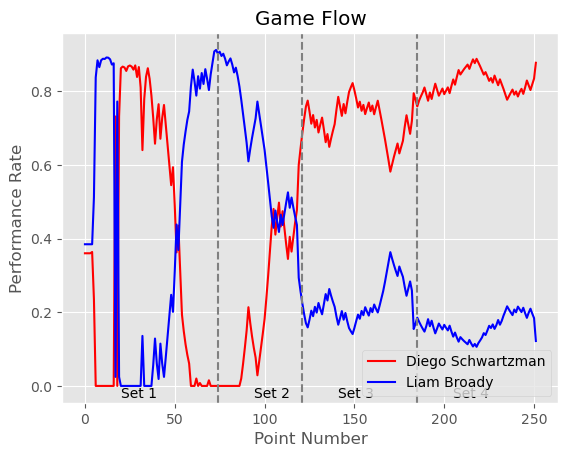

Diego Schwartzman is winning going into set 3 with:  0.6857286347107858 momentum
Diego Schwartzman is winning going into set 4 with:  0.7586477858803247 momentum
set 3 prediction is correct
set 4 prediction is correct


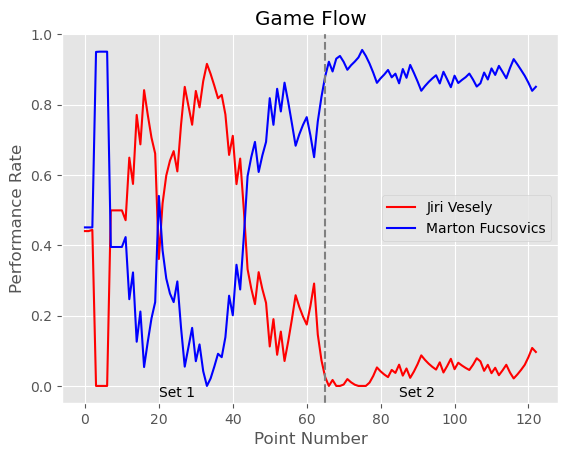

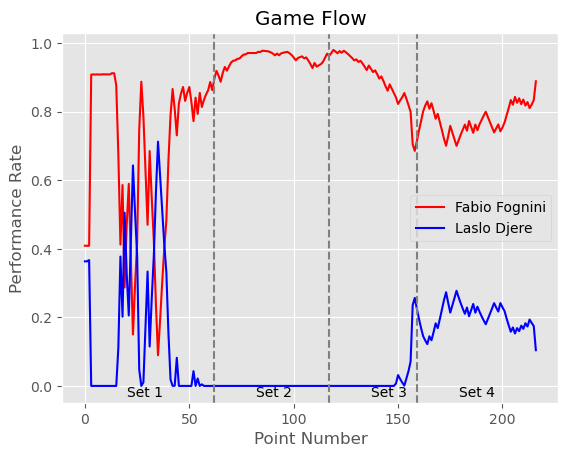

Fabio Fognini is winning going into set 3 with:  0.9632021909076841 momentum
Fabio Fognini is winning going into set 4 with:  0.7141663672966828 momentum
set 3 prediction is correct
set 4 prediction is correct


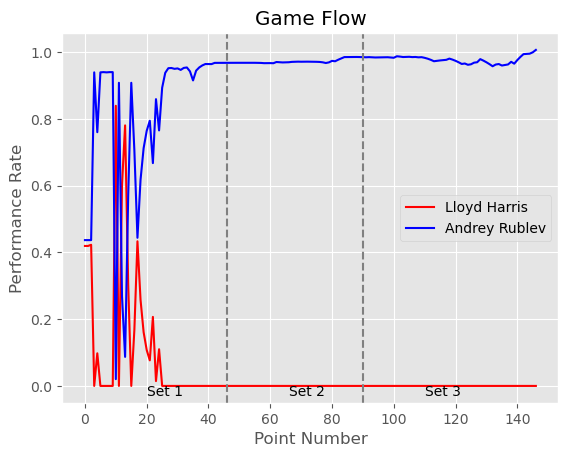

Andrey Rublev is winning going into set 3 with:  0.9854502498272854 momentum
set 3 prediction is correct


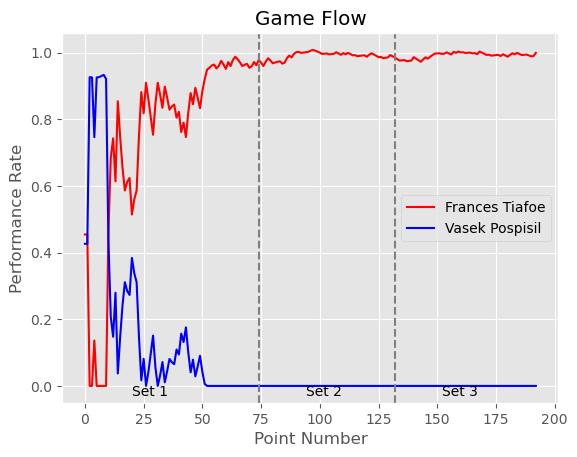

Frances Tiafoe is winning going into set 3 with:  0.985192651899562 momentum
set 3 prediction is correct


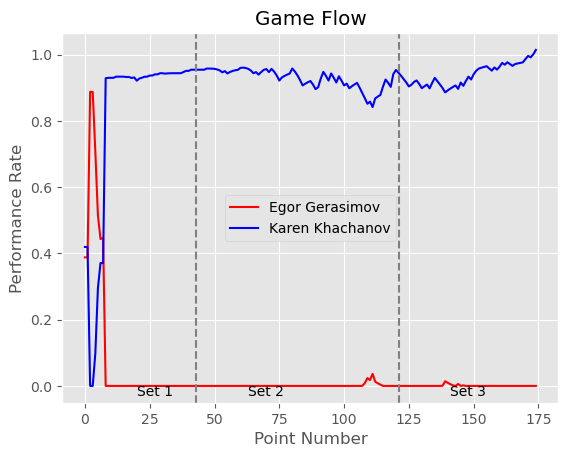

Karen Khachanov is winning going into set 3 with:  0.945186467932887 momentum
set 3 prediction is correct


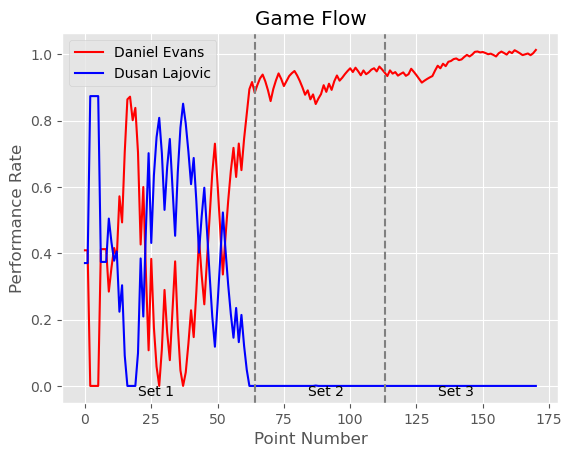

Daniel Evans is winning going into set 3 with:  0.9450498558078118 momentum
set 3 prediction is correct


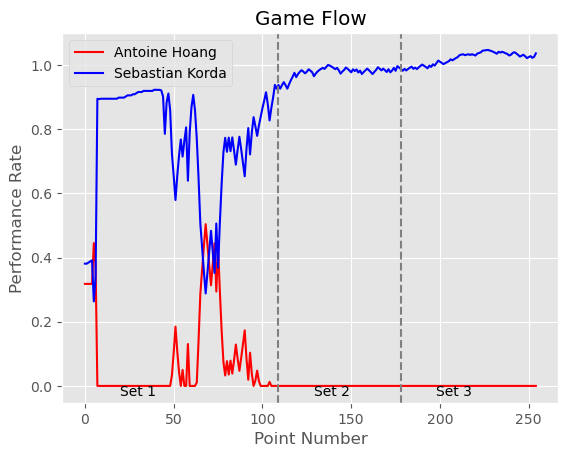

Sebastian Korda is winning going into set 3 with:  0.9873903649540579 momentum
set 3 prediction is correct


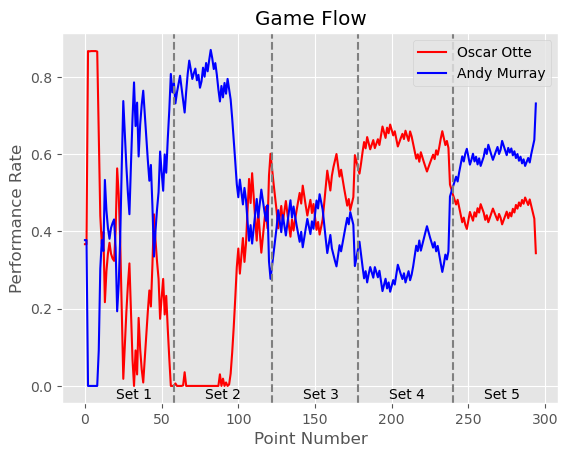

Oscar Otte is winning going into set 3 with:  0.5618391488633104 momentum
Oscar Otte is winning going into set 4 with:  0.5648633986066598 momentum
Andy Murray is winning going into set 5 with:  0.5166282759824459 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is correct


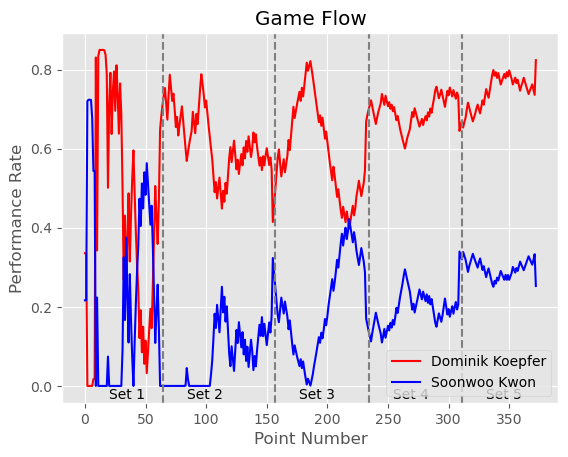

Dominik Koepfer is winning going into set 3 with:  0.4945738444661065 momentum
Dominik Koepfer is winning going into set 4 with:  0.6979710622181007 momentum
Dominik Koepfer is winning going into set 5 with:  0.6693812781178206 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


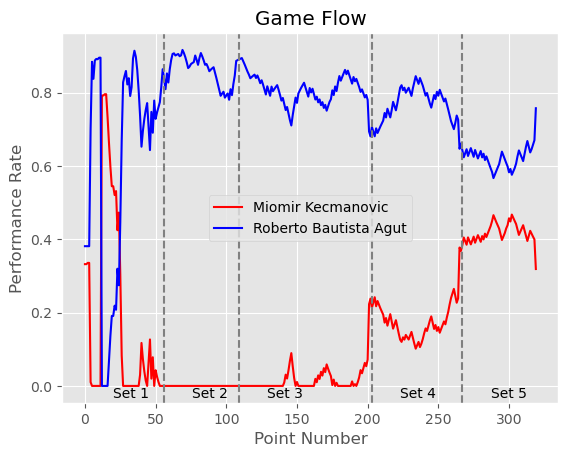

Roberto Bautista Agut is winning going into set 3 with:  0.8904750180035862 momentum
Roberto Bautista Agut is winning going into set 4 with:  0.7063844535378443 momentum
Roberto Bautista Agut is winning going into set 5 with:  0.6422744414087181 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


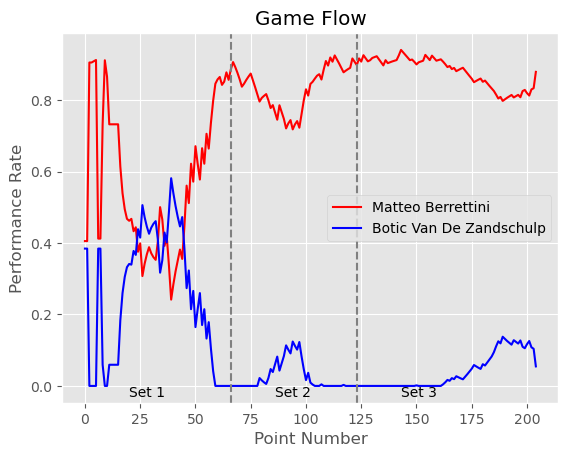

Matteo Berrettini is winning going into set 3 with:  0.8981480932063747 momentum
set 3 prediction is correct


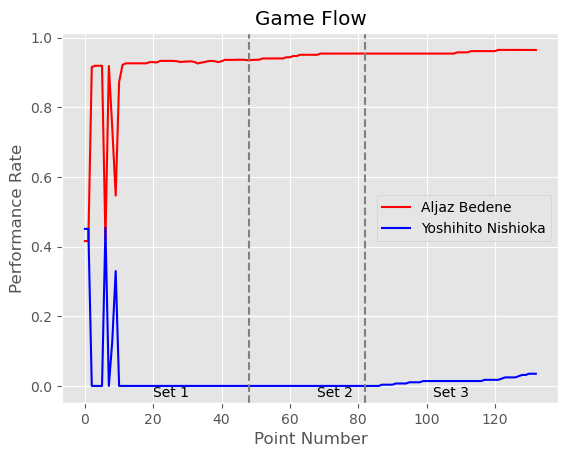

Aljaz Bedene is winning going into set 3 with:  0.9544995550883204 momentum
set 3 prediction is correct


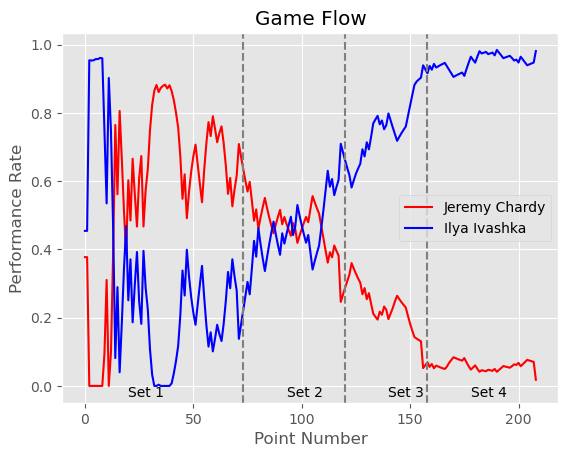

Ilya Ivashka is winning going into set 3 with:  0.661345344358798 momentum
Ilya Ivashka is winning going into set 4 with:  0.9165062227665384 momentum
set 3 prediction is correct
set 4 prediction is correct


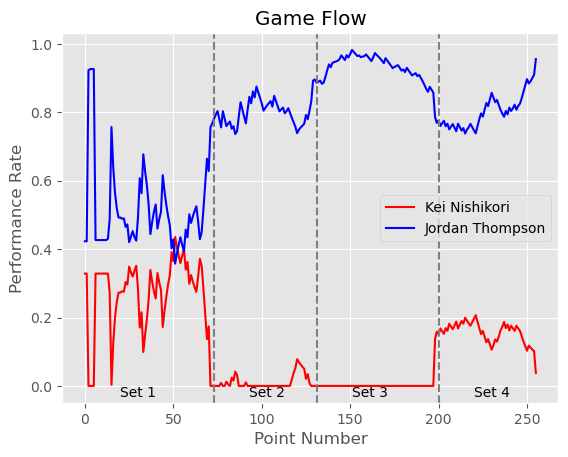

Jordan Thompson is winning going into set 3 with:  0.8865938156048162 momentum
Jordan Thompson is winning going into set 4 with:  0.7767216817069186 momentum
set 3 prediction is correct
set 4 prediction is correct


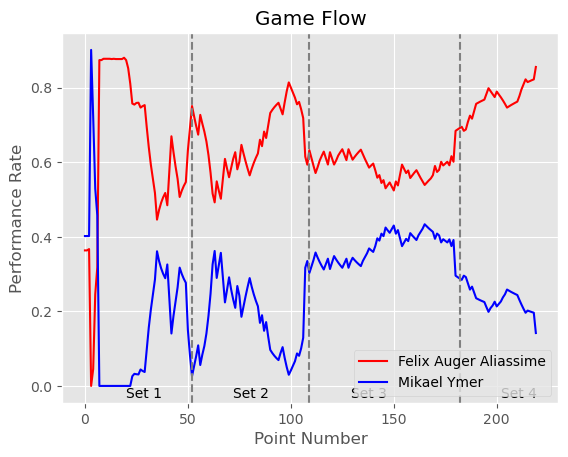

Felix Auger Aliassime is winning going into set 3 with:  0.6323043902274714 momentum
Felix Auger Aliassime is winning going into set 4 with:  0.6916816801834641 momentum
set 3 prediction is correct
set 4 prediction is correct


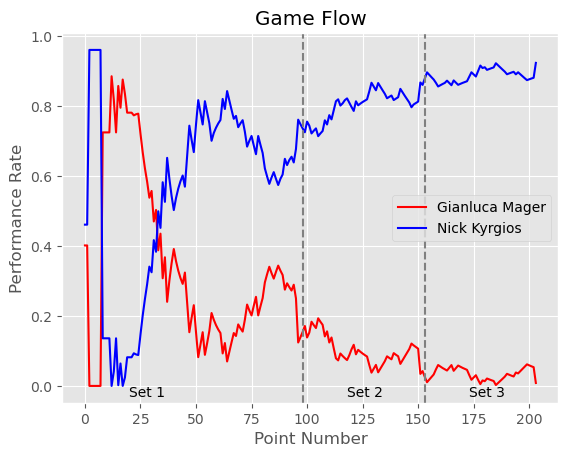

Nick Kyrgios is winning going into set 3 with:  0.8794972141694734 momentum
set 3 prediction is correct


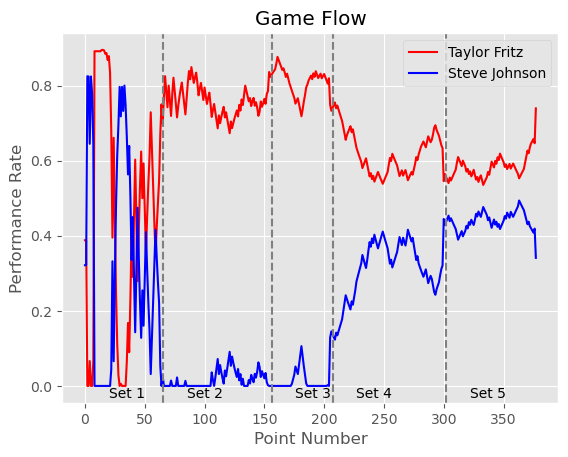

Taylor Fritz is winning going into set 3 with:  0.8288227521116764 momentum
Taylor Fritz is winning going into set 4 with:  0.7406202822333224 momentum
Taylor Fritz is winning going into set 5 with:  0.555995684182855 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


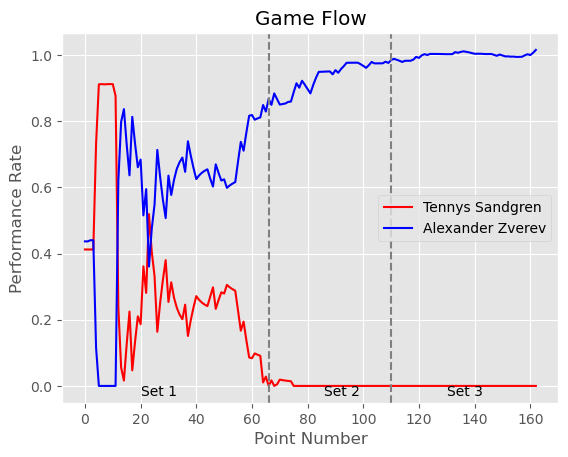

Alexander Zverev is winning going into set 3 with:  0.9851380096479103 momentum
set 3 prediction is correct


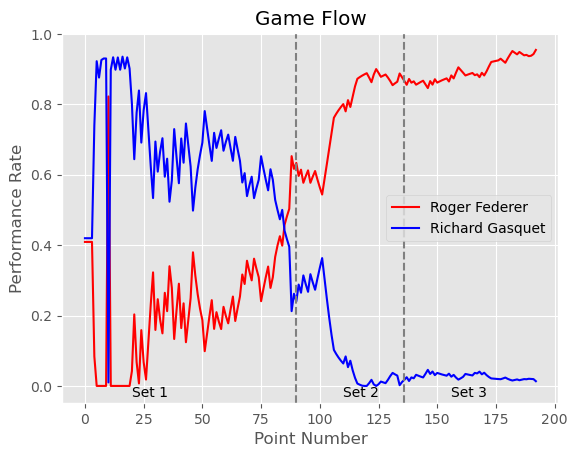

Roger Federer is winning going into set 3 with:  0.8663837475279771 momentum
set 3 prediction is correct


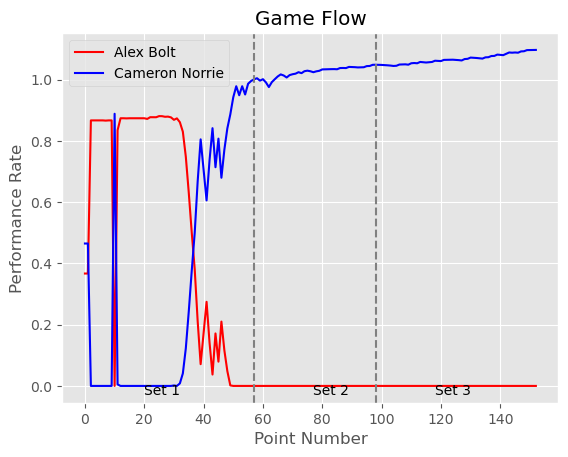

Cameron Norrie is winning going into set 3 with:  1.0487034574147698 momentum
set 3 prediction is correct


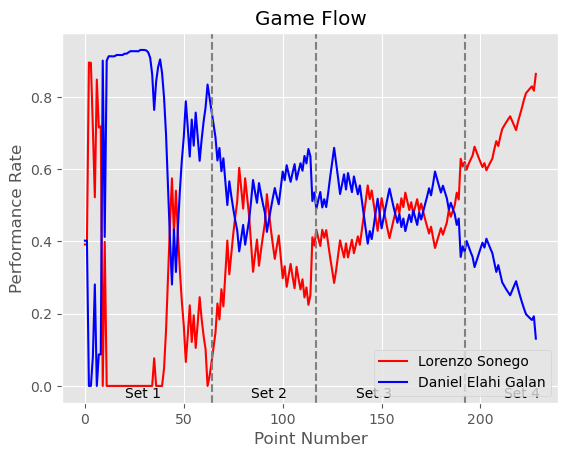

Daniel Elahi Galan is winning going into set 3 with:  0.4902263312522586 momentum
Lorenzo Sonego is winning going into set 4 with:  0.6197240406946556 momentum
set 3 prediction is wrong
set 4 prediction is correct


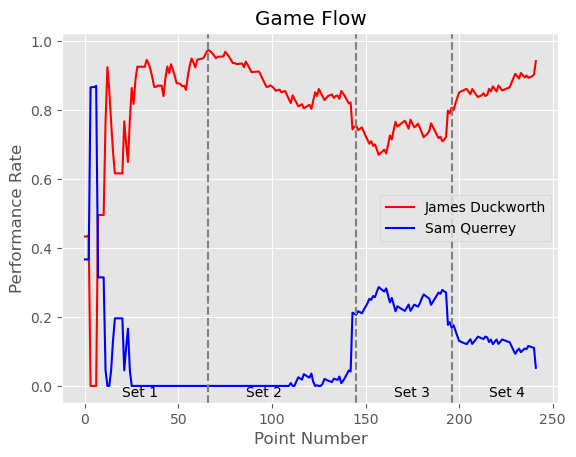

James Duckworth is winning going into set 3 with:  0.7554040583014398 momentum
James Duckworth is winning going into set 4 with:  0.8075647886001256 momentum
set 3 prediction is correct
set 4 prediction is correct


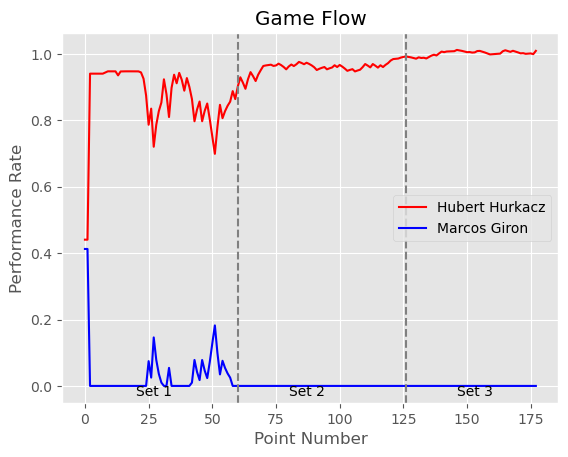

Hubert Hurkacz is winning going into set 3 with:  0.9923162708484996 momentum
set 3 prediction is correct


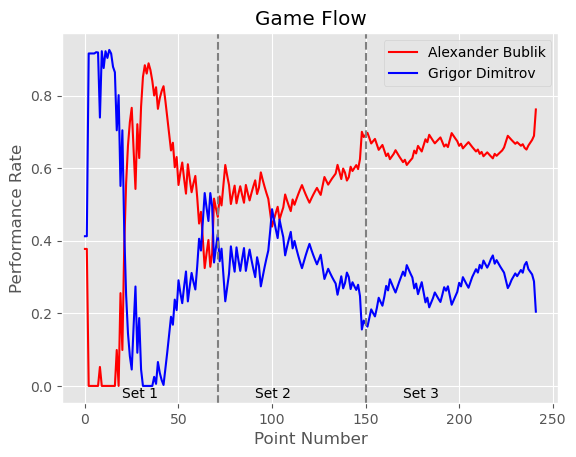

Alexander Bublik is winning going into set 3 with:  0.6917097557881721 momentum
set 3 prediction is correct


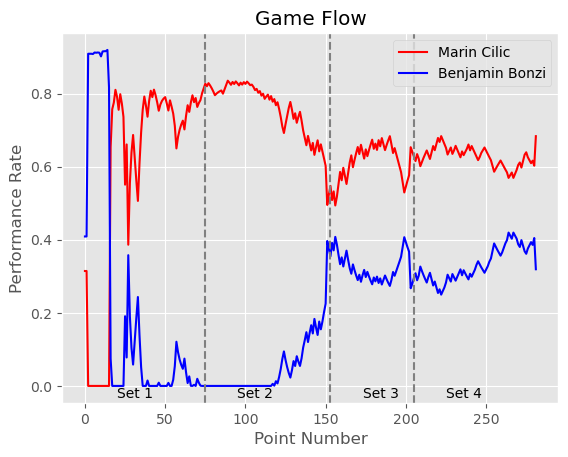

Marin Cilic is winning going into set 3 with:  0.5473553247340253 momentum
Marin Cilic is winning going into set 4 with:  0.6279463434854454 momentum
set 3 prediction is correct
set 4 prediction is correct


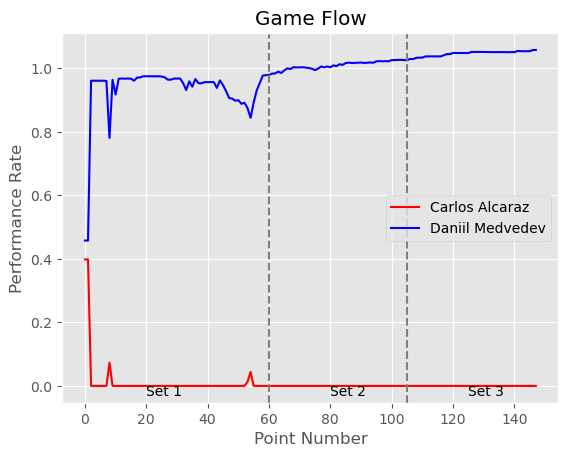

Daniil Medvedev is winning going into set 3 with:  1.0261041911506958 momentum
set 3 prediction is correct


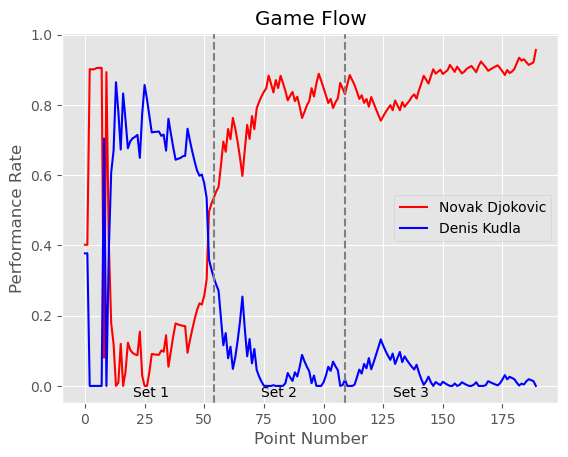

Novak Djokovic is winning going into set 3 with:  0.8308055676922561 momentum
set 3 prediction is correct


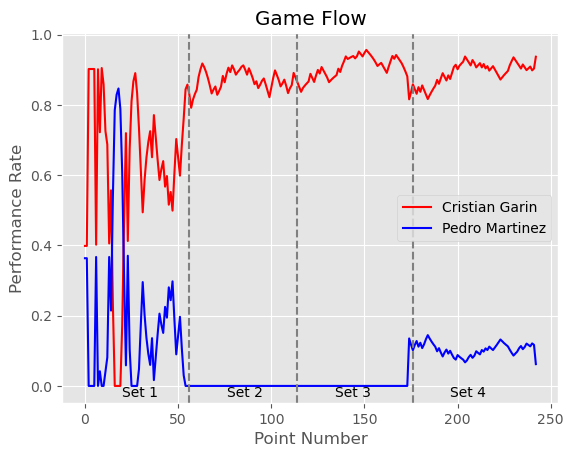

Cristian Garin is winning going into set 3 with:  0.8645892965215796 momentum
Cristian Garin is winning going into set 4 with:  0.8585008565795902 momentum
set 3 prediction is correct
set 4 prediction is correct


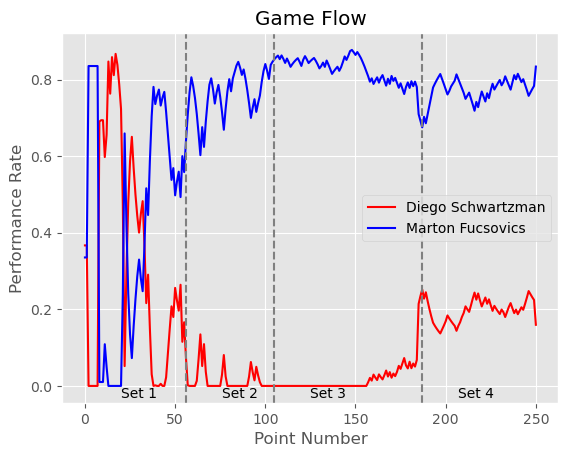

Marton Fucsovics is winning going into set 3 with:  0.8530930900263244 momentum
Marton Fucsovics is winning going into set 4 with:  0.6752831830774927 momentum
set 3 prediction is correct
set 4 prediction is correct


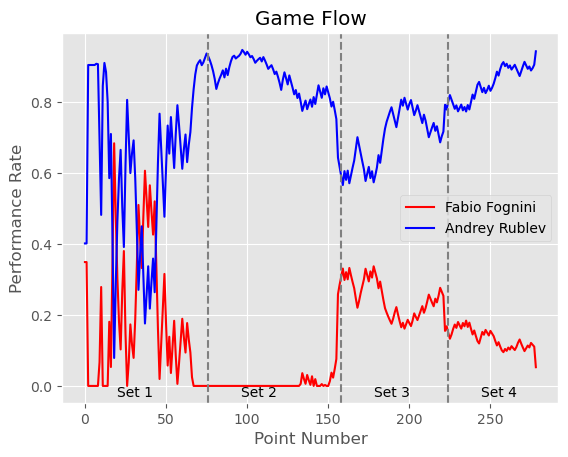

Andrey Rublev is winning going into set 3 with:  0.5919739250577108 momentum
Andrey Rublev is winning going into set 4 with:  0.8023957954903909 momentum
set 3 prediction is correct
set 4 prediction is correct


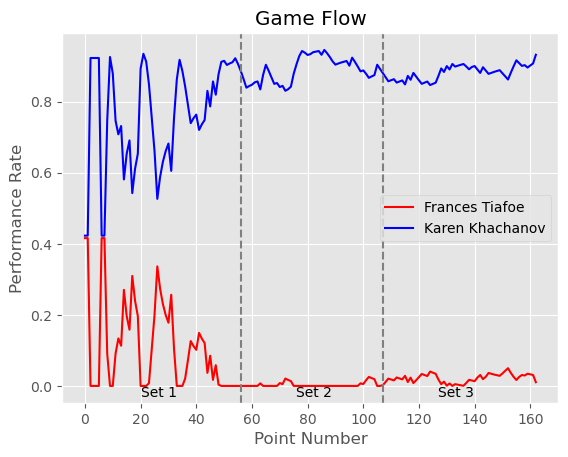

Karen Khachanov is winning going into set 3 with:  0.880898876885624 momentum
set 3 prediction is correct


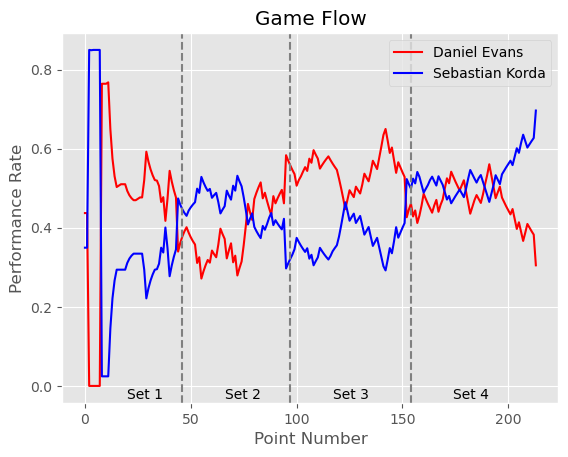

Daniel Evans is winning going into set 3 with:  0.55733452749378 momentum
Sebastian Korda is winning going into set 4 with:  0.4987003244815632 momentum
set 3 prediction is wrong
set 4 prediction is correct


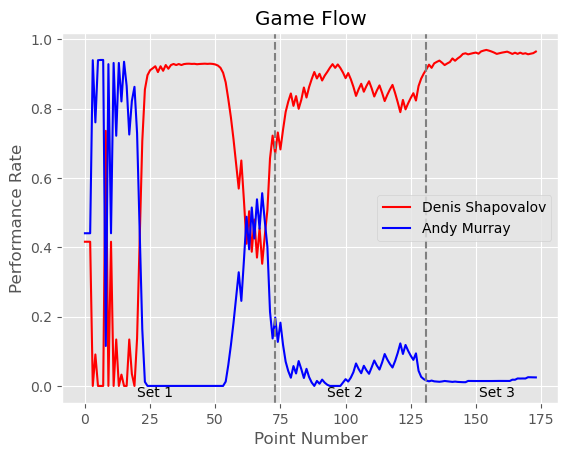

Denis Shapovalov is winning going into set 3 with:  0.9135840774992233 momentum
set 3 prediction is correct


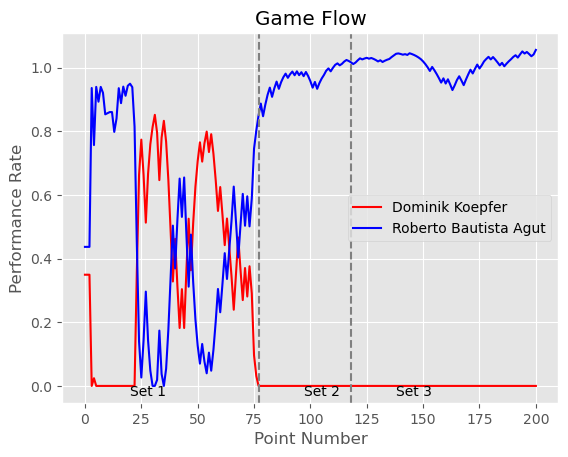

Roberto Bautista Agut is winning going into set 3 with:  1.016992139474057 momentum
set 3 prediction is correct


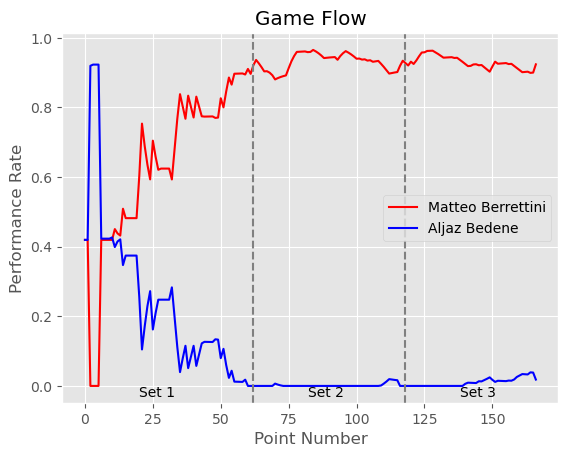

Matteo Berrettini is winning going into set 3 with:  0.9274534640647887 momentum
set 3 prediction is correct


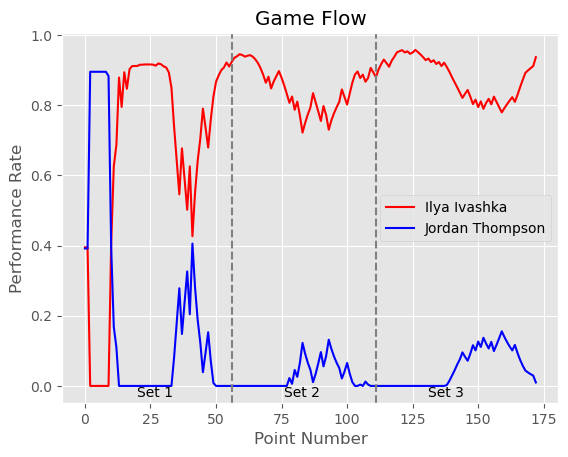

Ilya Ivashka is winning going into set 3 with:  0.8796311739557092 momentum
set 3 prediction is correct


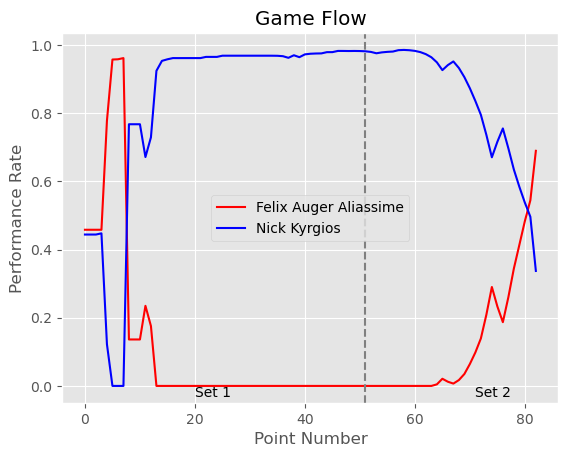

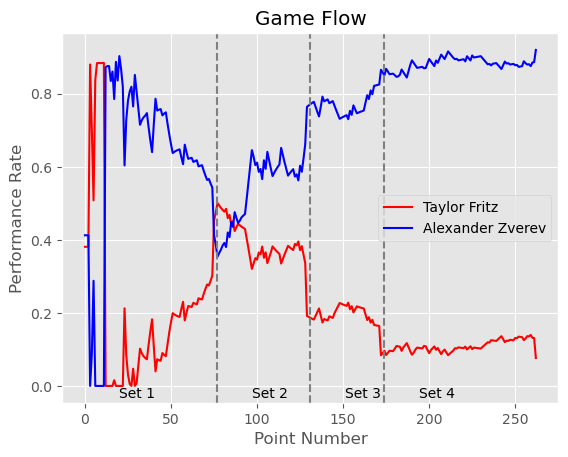

Alexander Zverev is winning going into set 3 with:  0.7717222913162778 momentum
Alexander Zverev is winning going into set 4 with:  0.850447513400835 momentum
set 3 prediction is correct
set 4 prediction is correct


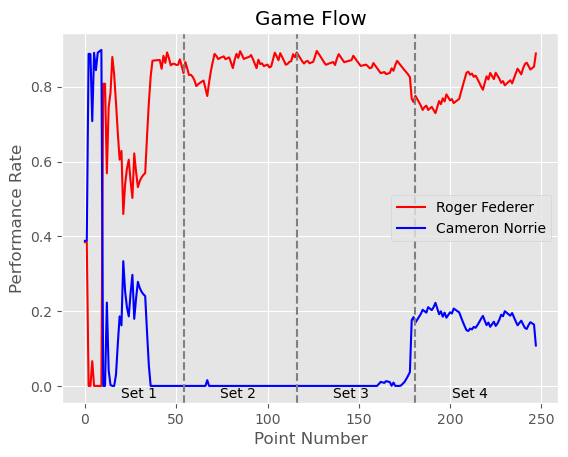

Roger Federer is winning going into set 3 with:  0.8915768587199836 momentum
Roger Federer is winning going into set 4 with:  0.7757790916114441 momentum
set 3 prediction is correct
set 4 prediction is correct


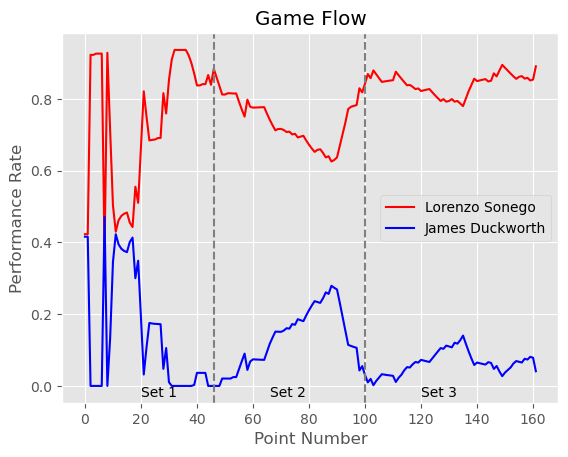

Lorenzo Sonego is winning going into set 3 with:  0.8427724789195115 momentum
set 3 prediction is correct


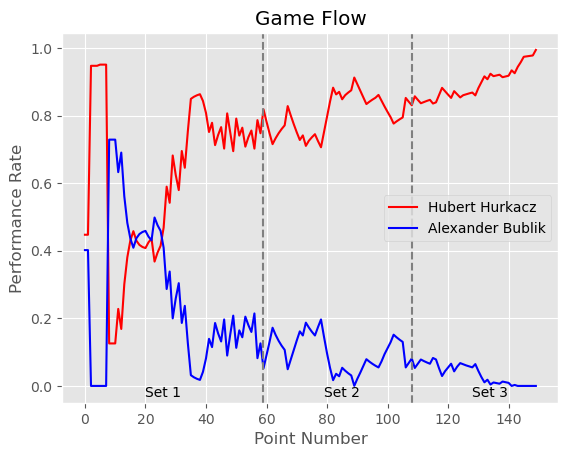

Hubert Hurkacz is winning going into set 3 with:  0.8307413358895445 momentum
set 3 prediction is correct


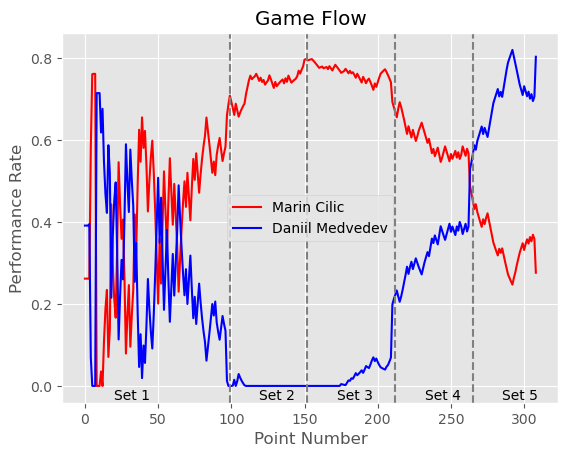

Marin Cilic is winning going into set 3 with:  0.7948585172222167 momentum
Marin Cilic is winning going into set 4 with:  0.6685610250858539 momentum
Daniil Medvedev is winning going into set 5 with:  0.5665345094085399 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is correct


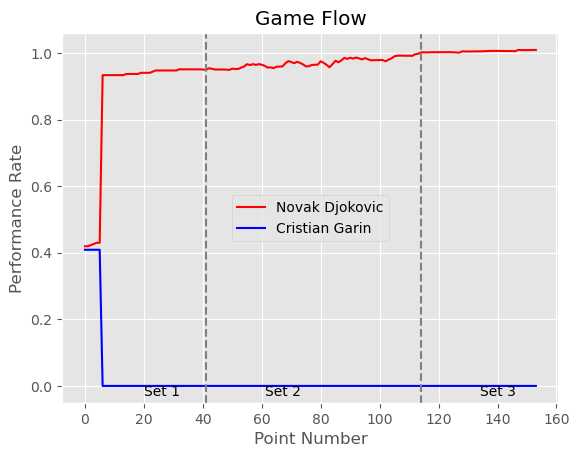

Novak Djokovic is winning going into set 3 with:  1.0016638938549494 momentum
set 3 prediction is correct


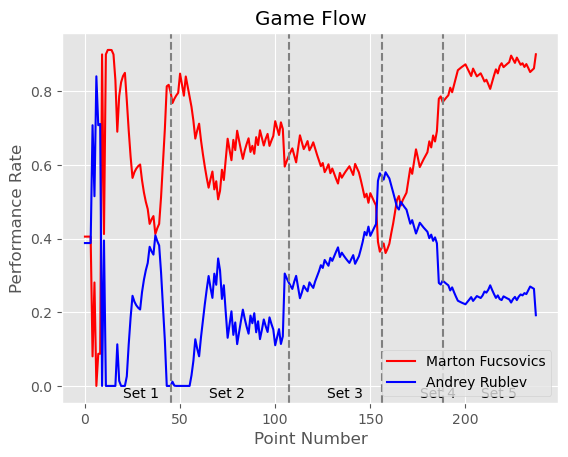

Marton Fucsovics is winning going into set 3 with:  0.6228703158020149 momentum
Andrey Rublev is winning going into set 4 with:  0.5686002346271322 momentum
Marton Fucsovics is winning going into set 5 with:  0.7707190391308143 momentum
set 3 prediction is correct
set 4 prediction is wrong
set 5 prediction is correct


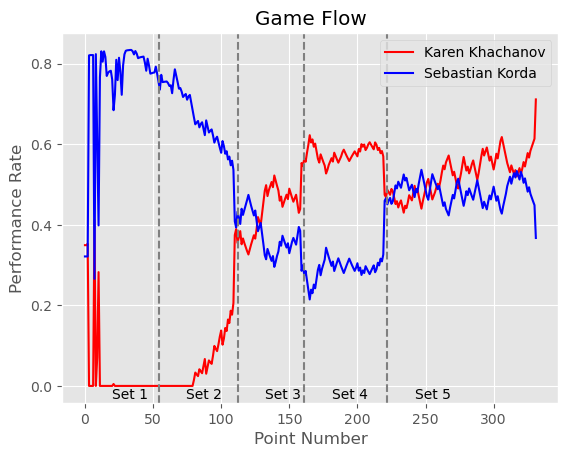

Sebastian Korda is winning going into set 3 with:  0.4326779746529756 momentum
Karen Khachanov is winning going into set 4 with:  0.5646119413660625 momentum
Karen Khachanov is winning going into set 5 with:  0.48682279133357653 momentum
set 3 prediction is wrong
set 4 prediction is correct
set 5 prediction is correct


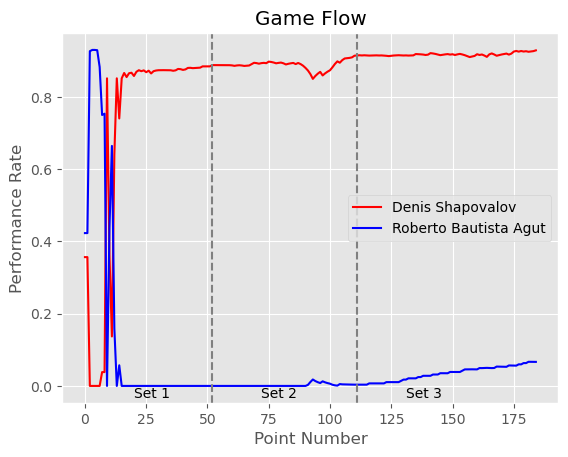

Denis Shapovalov is winning going into set 3 with:  0.914766377848465 momentum
set 3 prediction is correct


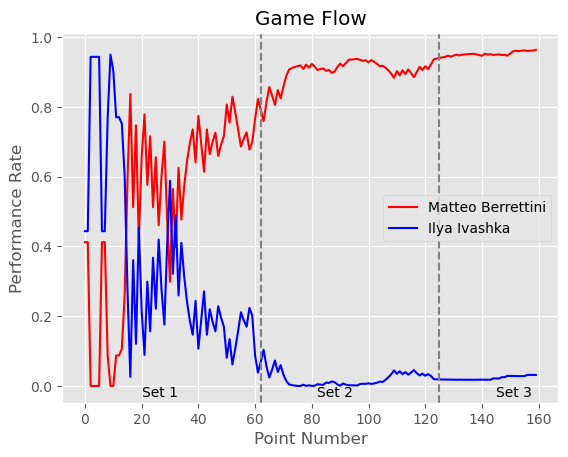

Matteo Berrettini is winning going into set 3 with:  0.9408778588335961 momentum
set 3 prediction is correct


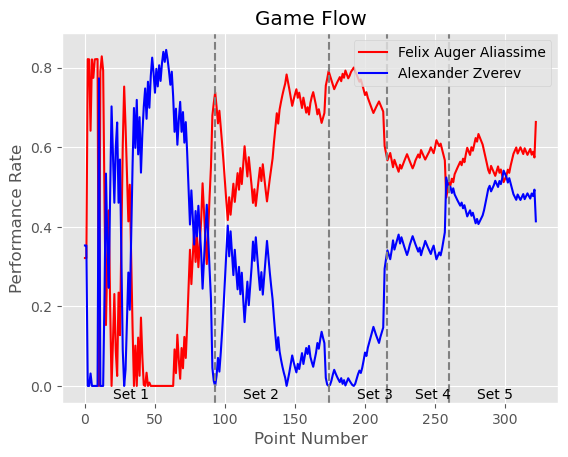

Felix Auger Aliassime is winning going into set 3 with:  0.7915023378740866 momentum
Felix Auger Aliassime is winning going into set 4 with:  0.5670059328154909 momentum
Felix Auger Aliassime is winning going into set 5 with:  0.5130707856528038 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


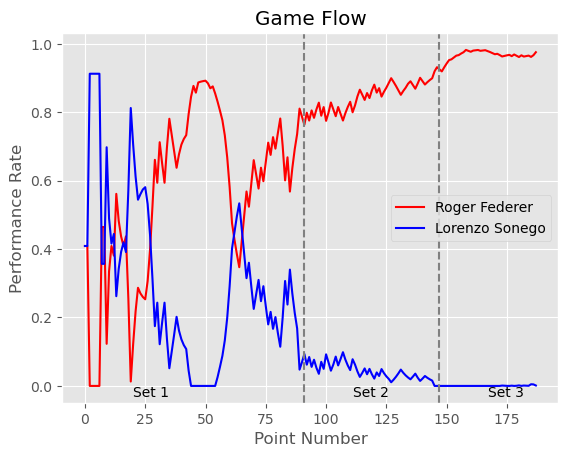

Roger Federer is winning going into set 3 with:  0.9256126824918628 momentum
set 3 prediction is correct


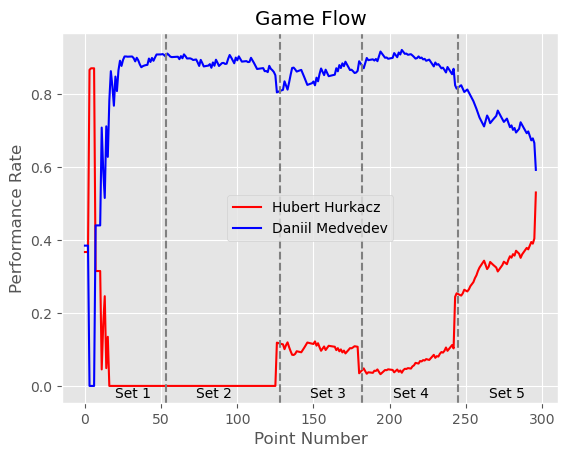

Daniil Medvedev is winning going into set 3 with:  0.8083604587520673 momentum
Daniil Medvedev is winning going into set 4 with:  0.8771346250534264 momentum
Daniil Medvedev is winning going into set 5 with:  0.817969333223153 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is wrong


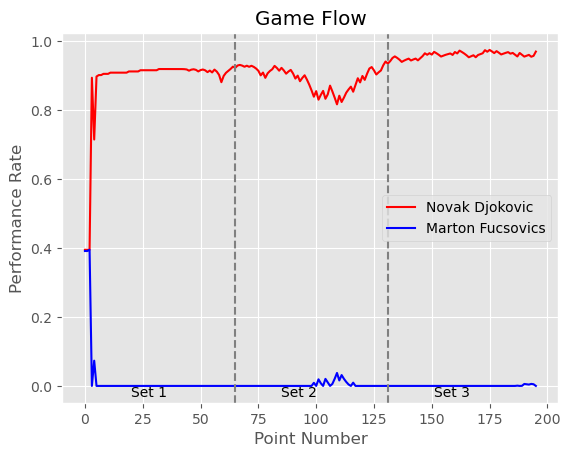

Novak Djokovic is winning going into set 3 with:  0.93531549912102 momentum
set 3 prediction is correct


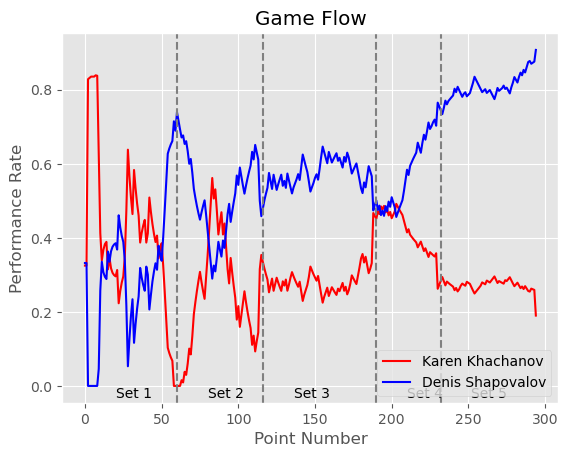

Denis Shapovalov is winning going into set 3 with:  0.47904902306093844 momentum
Denis Shapovalov is winning going into set 4 with:  0.5008906483652306 momentum
Denis Shapovalov is winning going into set 5 with:  0.7444363501700331 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


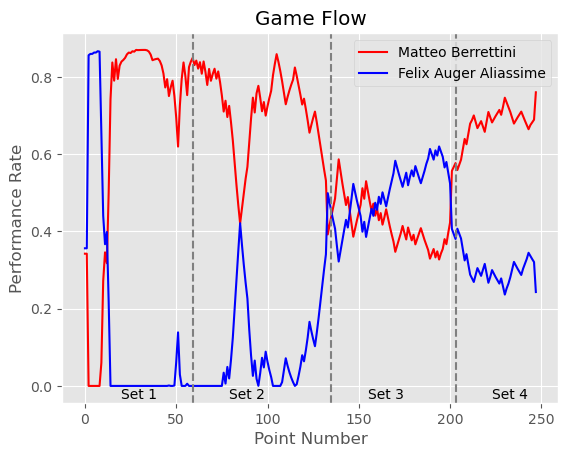

Felix Auger Aliassime is winning going into set 3 with:  0.4505181216673124 momentum
Matteo Berrettini is winning going into set 4 with:  0.5771340595484447 momentum
set 3 prediction is wrong
set 4 prediction is correct


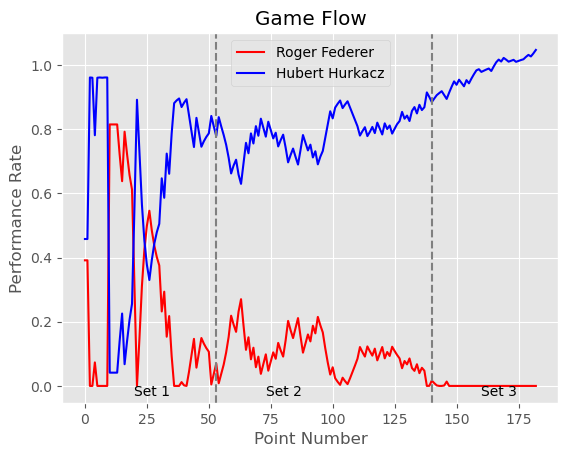

Hubert Hurkacz is winning going into set 3 with:  0.8848661699158334 momentum
set 3 prediction is correct


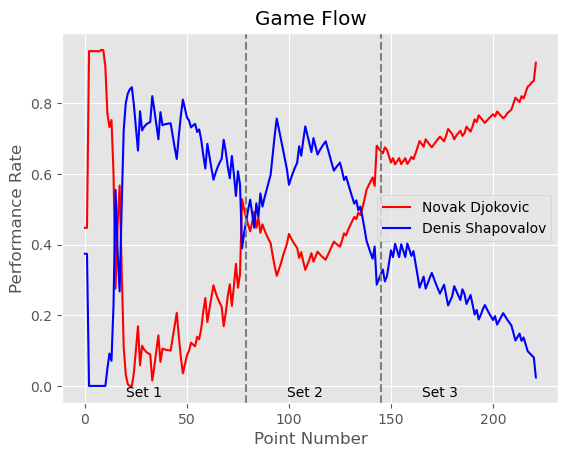

Novak Djokovic is winning going into set 3 with:  0.6649500315236422 momentum
set 3 prediction is correct


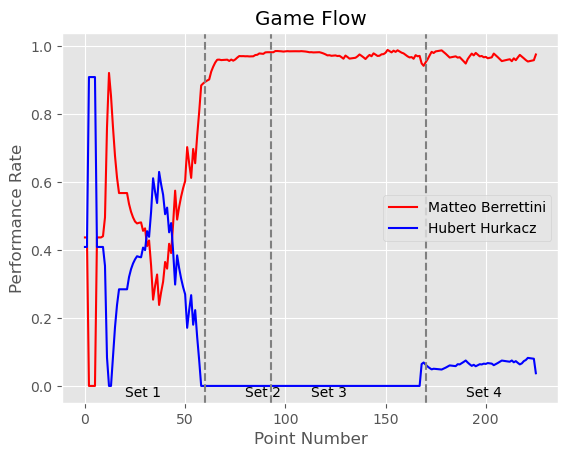

Matteo Berrettini is winning going into set 3 with:  0.9820178568026069 momentum
Matteo Berrettini is winning going into set 4 with:  0.9524082092005214 momentum
set 3 prediction is correct
set 4 prediction is correct


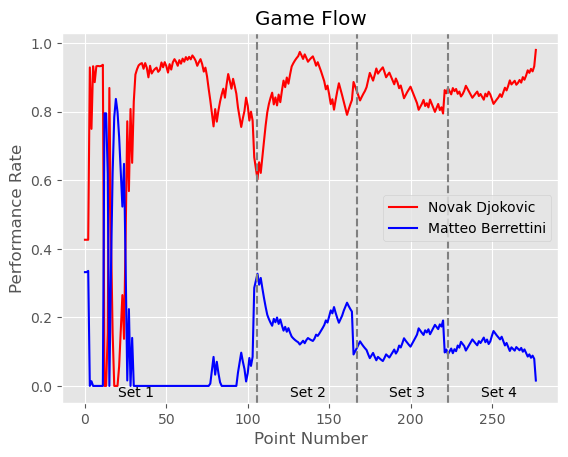

Novak Djokovic is winning going into set 3 with:  0.8602921938295395 momentum
Novak Djokovic is winning going into set 4 with:  0.8689863666082543 momentum
set 3 prediction is correct
set 4 prediction is correct
Predicted winner at set 2 correctly [96] / 125 times
Predicted winner at set 3 correctly [92] / 121 times
Predicted winner at set 4 correctly [57] / 68 times
Predicted winner at set 5 correctly [18] / 25 times


In [105]:
if False:
    FILE = '2023-wimbledon-data.csv'
    # 2023 Matches
    MATCHES_TO_EXAMINE = ['2023-wimbledon-1301', '2023-wimbledon-1302', '2023-wimbledon-1303', '2023-wimbledon-1304', '2023-wimbledon-1305','2023-wimbledon-1306','2023-wimbledon-1307','2023-wimbledon-1308','2023-wimbledon-1309',
                        '2023-wimbledon-1310','2023-wimbledon-1311','2023-wimbledon-1312','2023-wimbledon-1313','2023-wimbledon-1314','2023-wimbledon-1315','2023-wimbledon-1316','2023-wimbledon-1401','2023-wimbledon-1402',
                        '2023-wimbledon-1403','2023-wimbledon-1404','2023-wimbledon-1405','2023-wimbledon-1406','2023-wimbledon-1407','2023-wimbledon-1408','2023-wimbledon-1501','2023-wimbledon-1502','2023-wimbledon-1503',
                        '2023-wimbledon-1504','2023-wimbledon-1601','2023-wimbledon-1602','2023-wimbledon-1701']
if True:
    FILE = '2021-wimbledon-data.csv'
    # 2021 Matches
    MATCHES_TO_EXAMINE = [
                        '2021-wimbledon-1101', '2021-wimbledon-1102', '2021-wimbledon-1103', '2021-wimbledon-1104', '2021-wimbledon-1105',
                        '2021-wimbledon-1106', '2021-wimbledon-1107', '2021-wimbledon-1108', '2021-wimbledon-1109', '2021-wimbledon-1110',
                        '2021-wimbledon-1111', '2021-wimbledon-1112', '2021-wimbledon-1113', '2021-wimbledon-1114', '2021-wimbledon-1115',
                        '2021-wimbledon-1116', '2021-wimbledon-1117', '2021-wimbledon-1118', '2021-wimbledon-1119', '2021-wimbledon-1120',
                        '2021-wimbledon-1121', '2021-wimbledon-1122', '2021-wimbledon-1123', '2021-wimbledon-1124', '2021-wimbledon-1125',
                        '2021-wimbledon-1126', '2021-wimbledon-1127', '2021-wimbledon-1128', '2021-wimbledon-1129', '2021-wimbledon-1130',
                        '2021-wimbledon-1131', '2021-wimbledon-1132', '2021-wimbledon-1133', '2021-wimbledon-1134', '2021-wimbledon-1135',
                        '2021-wimbledon-1136', '2021-wimbledon-1137', '2021-wimbledon-1138', '2021-wimbledon-1139', '2021-wimbledon-1140',
                        '2021-wimbledon-1141', '2021-wimbledon-1142', '2021-wimbledon-1143', '2021-wimbledon-1144', '2021-wimbledon-1145',
                        '2021-wimbledon-1146', '2021-wimbledon-1147', '2021-wimbledon-1148', '2021-wimbledon-1150', '2021-wimbledon-1151', 
                        '2021-wimbledon-1152', '2021-wimbledon-1153', '2021-wimbledon-1154', '2021-wimbledon-1155', '2021-wimbledon-1156', 
                        '2021-wimbledon-1157', '2021-wimbledon-1158', '2021-wimbledon-1159', '2021-wimbledon-1160', '2021-wimbledon-1161', 
                        '2021-wimbledon-1162', '2021-wimbledon-1163', '2021-wimbledon-1164', '2021-wimbledon-1201', '2021-wimbledon-1202', 
                        '2021-wimbledon-1203', '2021-wimbledon-1204', '2021-wimbledon-1205', '2021-wimbledon-1206', '2021-wimbledon-1207', 
                        '2021-wimbledon-1208', '2021-wimbledon-1209', '2021-wimbledon-1210', '2021-wimbledon-1211', '2021-wimbledon-1212', 
                        '2021-wimbledon-1214', '2021-wimbledon-1215', '2021-wimbledon-1216', '2021-wimbledon-1217', '2021-wimbledon-1218', 
                        '2021-wimbledon-1219', '2021-wimbledon-1220', '2021-wimbledon-1221', '2021-wimbledon-1222', '2021-wimbledon-1223', 
                        '2021-wimbledon-1224', '2021-wimbledon-1225', '2021-wimbledon-1226', '2021-wimbledon-1227', '2021-wimbledon-1228', 
                        '2021-wimbledon-1229', '2021-wimbledon-1230', '2021-wimbledon-1231', '2021-wimbledon-1232', '2021-wimbledon-1301', 
                        '2021-wimbledon-1302', '2021-wimbledon-1303', '2021-wimbledon-1304', '2021-wimbledon-1305', '2021-wimbledon-1306', 
                        '2021-wimbledon-1307', '2021-wimbledon-1308', '2021-wimbledon-1309', '2021-wimbledon-1310', '2021-wimbledon-1311', 
                        '2021-wimbledon-1312', '2021-wimbledon-1313', '2021-wimbledon-1314', '2021-wimbledon-1315', '2021-wimbledon-1316', 
                        '2021-wimbledon-1401', '2021-wimbledon-1402', '2021-wimbledon-1403', '2021-wimbledon-1404', '2021-wimbledon-1405', 
                        '2021-wimbledon-1406', '2021-wimbledon-1407', '2021-wimbledon-1408', '2021-wimbledon-1501', '2021-wimbledon-1502', 
                        '2021-wimbledon-1503', '2021-wimbledon-1504', '2021-wimbledon-1601', '2021-wimbledon-1602', '2021-wimbledon-1701']

set1_correct = set1_total = set2_correct = set2_total = set3_correct = set3_total = set4_correct = set4_total = 0

for MATCH_TO_EXAMINE in MATCHES_TO_EXAMINE:
    model = MarkovChain(FILE, MATCH_TO_EXAMINE)
    model.train()
    model.graph_momentum()
    result_array = model.prediction()

    try:
        set1_correct += result_array[0]
        set1_total += 1

        set2_correct += result_array[1]
        set2_total += 1

        set3_correct += result_array[2]
        set3_total += 1

        set4_correct += result_array[3]
        set4_total += 1
    finally:
        continue

print(f"Predicted winner at set 2 correctly {set1_correct} / {set1_total} times")
print(f"Predicted winner at set 3 correctly {set2_correct} / {set2_total} times")
print(f"Predicted winner at set 4 correctly {set3_correct} / {set3_total} times")
print(f"Predicted winner at set 5 correctly {set4_correct} / {set4_total} times")